In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def expo_pulse(x,a1,tau1,a2,tau2):
    return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)

In [4]:
def AR_filter(wf, tau):
    if wf.shape[0]>1:#multiple waveforms
        wf = wf.transpose()
    wf_filt = np.zeros(wf.shape)
    for i,raw in enumerate(list(reversed(wf))):
        if i>0:
            wf_filt[i] = raw + wf_filt[i-1]*np.exp(-1/tau)
        else:
            wf_filt[i] = raw
    return np.array(list(reversed(wf_filt))).transpose()

# Top tile calibration (0928 data)

The 0928 datasets use laser pulses as the external trigger.

## Directories

In [5]:
voltages = ['20220928_top_61V_laser_ext',
            '20220928_top_63V_laser_ext',
            '20220928_top_65V_laser_ext',
            '20220928_top_67V_laser_ext',
            '20220928_top_69V_laser_ext']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

ch0 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch0 20220928_top_63V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch0 20220928_top_65V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch0 20220928_top_67V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch0 20220928_top_69V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch1 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch1 20220928_top_63V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch1 20220928_top_65V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch1 20220928_top_67V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch1 20220928_top_69V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch2 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_top_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_top_65V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch2 20220928_top_67V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch2 20220928_top_69V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch3 20220928_top_61V_laser_ext
  TRIGGER POSITION = SAM

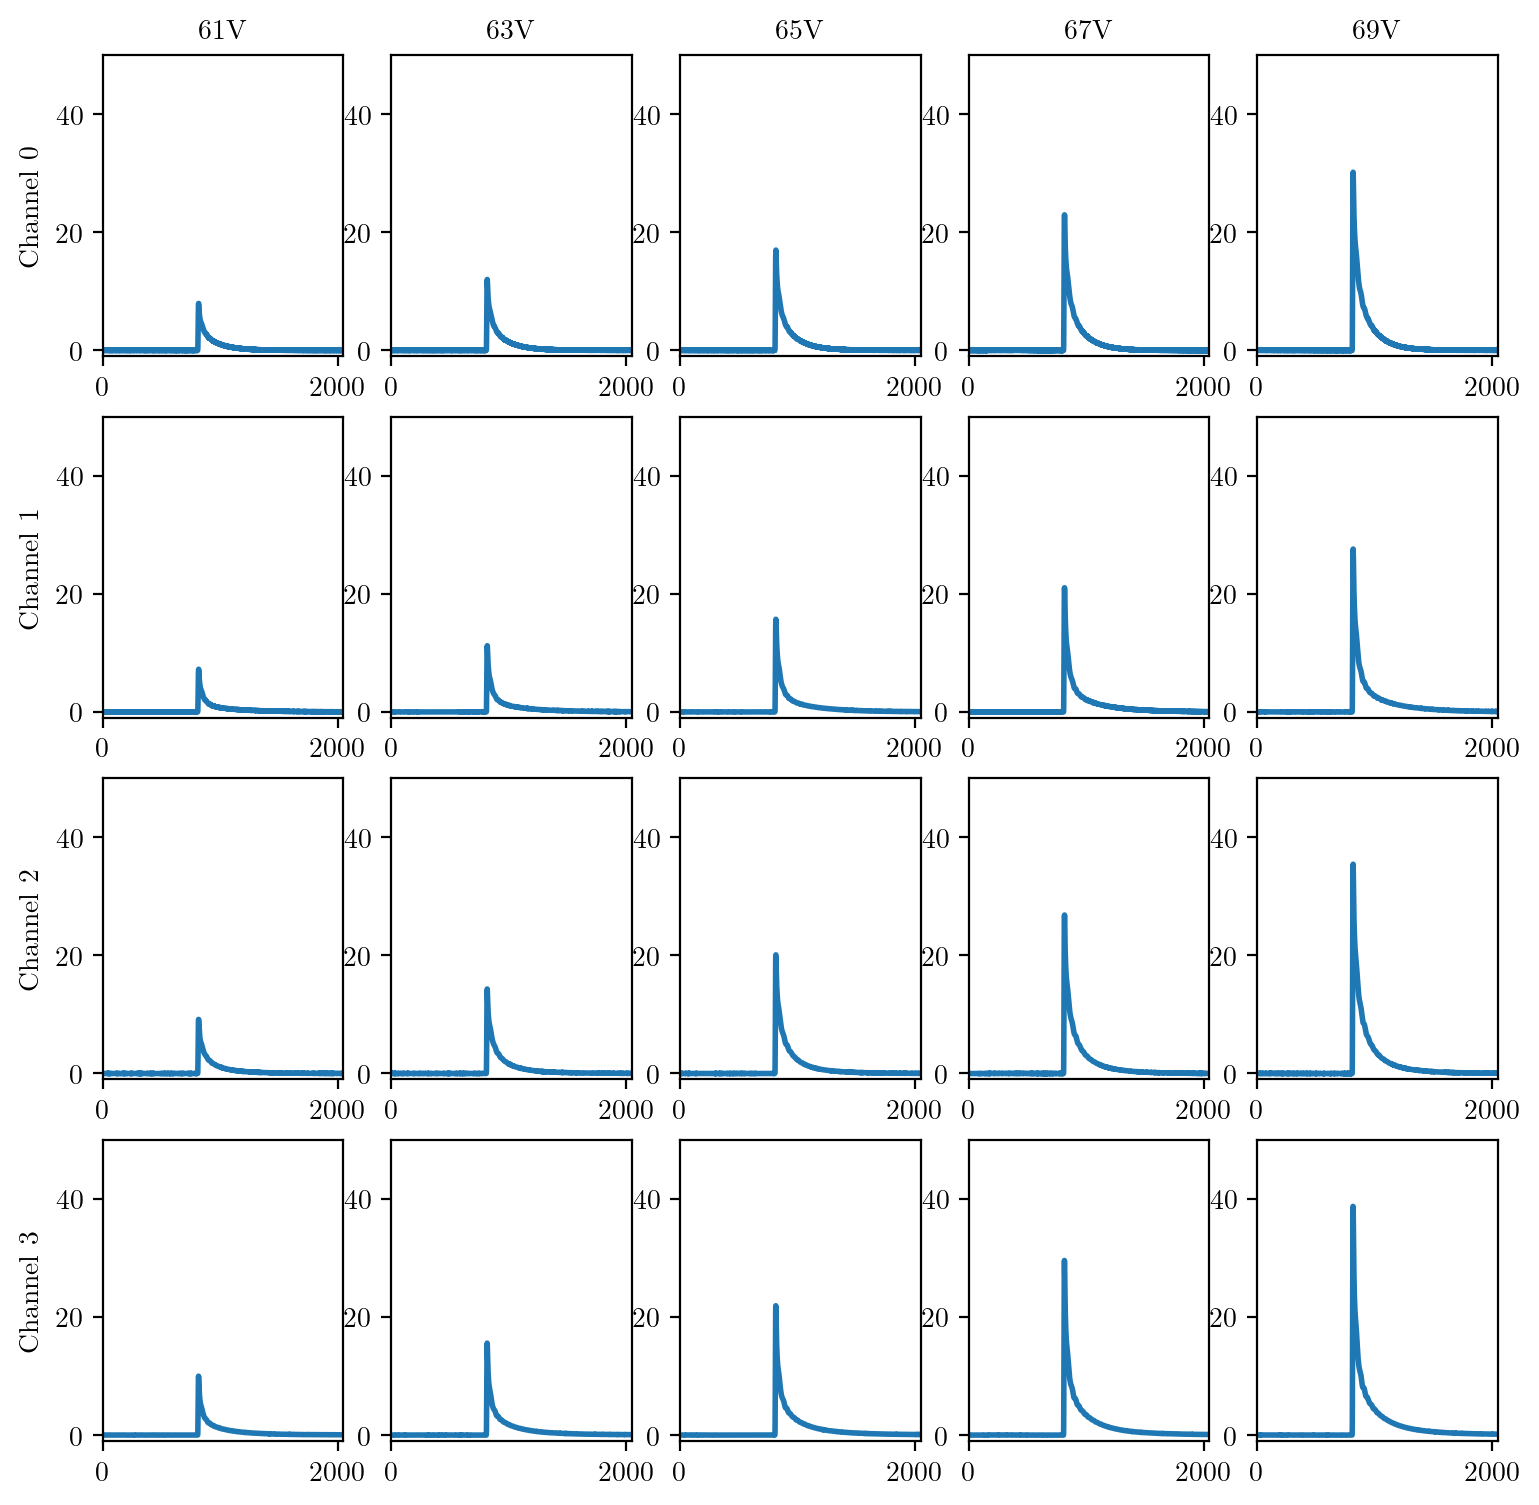

In [7]:
#waveform length in samples
length = 2048
#total events
nevents = 100000
#pretrigger baseline length
bsl_length = 800
#charge histogram
nbins_charge = 1000
h_charge_ch_volt = np.zeros((4,5,nbins_charge))
h_charge_bincent_ch_volt = np.zeros((4,5,nbins_charge))
h_charge_binwid_ch_volt = np.zeros((4,5))
#charge integral range
tmin = 800
tmax = 1200
#filtered amplitude histogram
nbins_famp = 1000
h_famp_ch_volt = np.zeros((4,5,nbins_famp))
h_famp_bincent_ch_volt = np.zeros((4,5,nbins_famp))
h_famp_binwid_ch_volt = np.zeros((4,5))
#AR time constant
tau = 20
#average waveform
avgwf_ch_volt = np.zeros((4,5,length))
avgwf_sample_ch_volt = np.zeros((4,5,length))
#for average waveforms
plt.figure(0,figsize=(9,9))
# bias voltage
bias = [61, 63, 65, 67, 69]

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,length)).astype(float)
        traces = np.tile(np.mean(traces[:,:bsl_length],axis=1).reshape(nevents,1),(1,length)) - traces
        integrals = np.sum(traces[:,tmin:tmax],axis=1)
        amps_filt = np.max(AR_filter(traces, tau),axis=1)
        
        #charge histogram
        h_charge_ch_volt[ch][volt_id], bin_edges = np.histogram(integrals, bins=np.linspace(0, 5000, nbins_charge+1))#linspace(min, max, nbins+1)
        h_charge_bincent_ch_volt[ch][volt_id] = (bin_edges[1:]+bin_edges[:-1])/2
        h_charge_binwid_ch_volt[ch][volt_id] = bin_edges[1]-bin_edges[0]

        #filtered amplitude histogram
        h_famp_ch_volt[ch][volt_id], bin_edges = np.histogram(amps_filt, bins=np.linspace(0, 1000, nbins_famp+1))#linspace(min, max, nbins+1)
        h_famp_bincent_ch_volt[ch][volt_id] = (bin_edges[1:]+bin_edges[:-1])/2
        h_famp_binwid_ch_volt[ch][volt_id] = bin_edges[1]-bin_edges[0]

        # spe average waveform
        # not implemented yet. for now average over all waveforms
        count = 0
        meanwf = np.mean(traces,axis=0)
        for wf_sub_bsl in traces:
            avgwf_ch_volt[ch][volt_id] = avgwf_ch_volt[ch][volt_id]*count + wf_sub_bsl
            count += 1
            avgwf_ch_volt[ch][volt_id] = avgwf_ch_volt[ch][volt_id]/count
        trig_pos = np.argmax(avgwf_ch_volt[ch][volt_id])
        print('  TRIGGER POSITION = SAMPLE {}'.format(trig_pos))
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        plt.xlim(0,2048)
        plt.ylim(-1, 50)

## Plot charge histogram and analyze

[ 98.61738081 428.48975863]
[141.22214011 465.33040523]
[178.34565278 524.32113898]
[205.22321506 601.4551956 ]
[225.99918903 691.88012911]
Channel 0 Vbd=54.172+/-0.246V
[ 48.97701511 371.87239892]
[ 99.97589656 429.58486212]
[129.39288934 488.05831244]
[158.54963176 589.74959679]
[159.27255638 663.67963223]
Channel 1 Vbd=54.617+/-0.306V
[ 75.30760905 393.82177359]
[124.33160816 454.71122089]
[162.18390888 533.71930245]
[200.20808274 644.87809202]
[214.82379687 699.86020464]
Channel 2 Vbd=54.419+/-0.225V
[ 33.10780361 408.83545424]
[ 83.51008445 466.16864145]
[122.21248684 541.81051115]
[140.97299534 646.79493819]
[156.79550364 724.85218643]
Channel 3 Vbd=55.152+/-0.300V


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage')

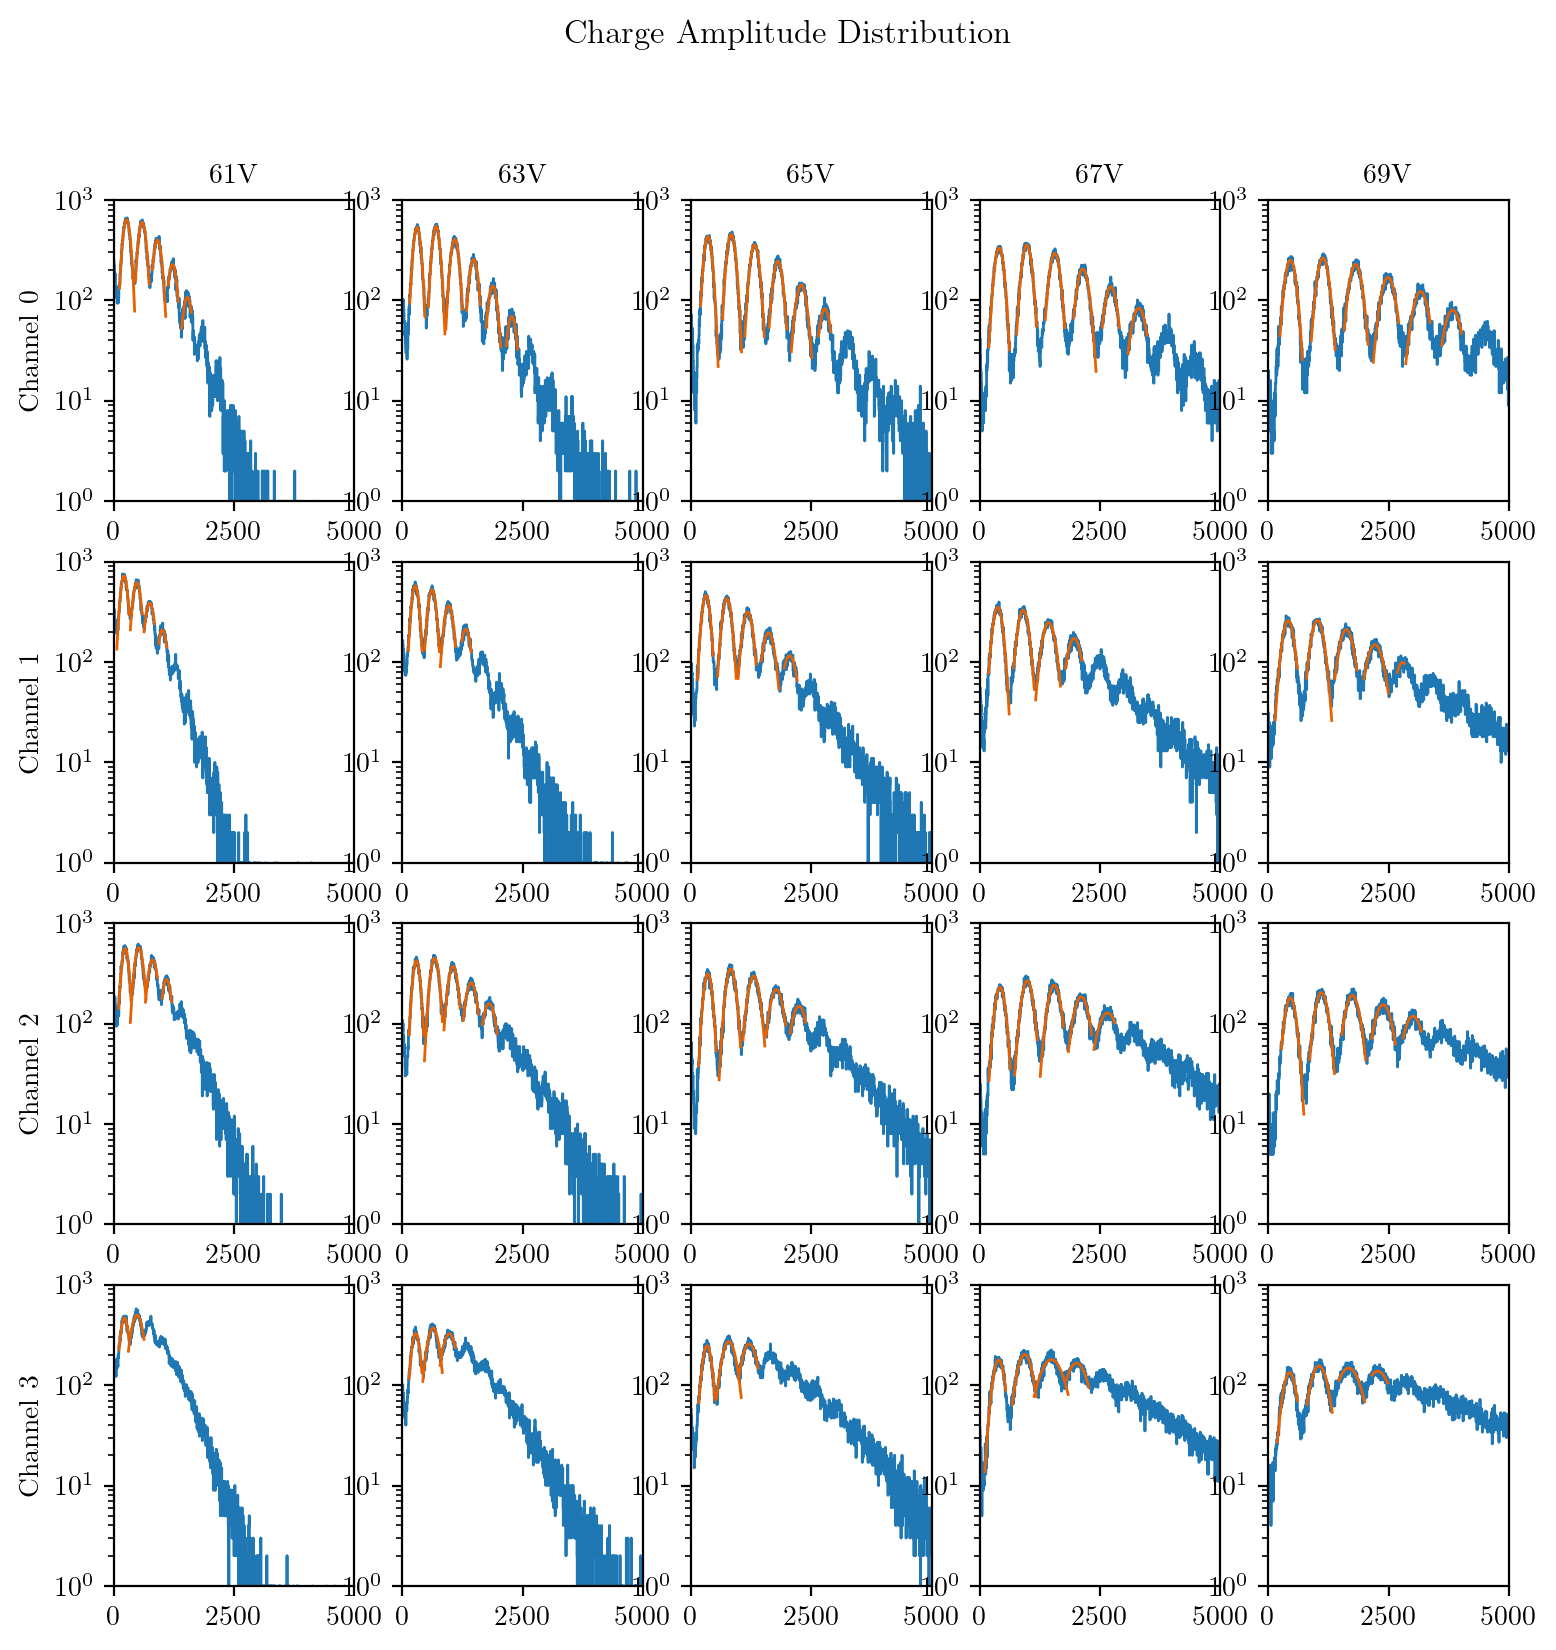

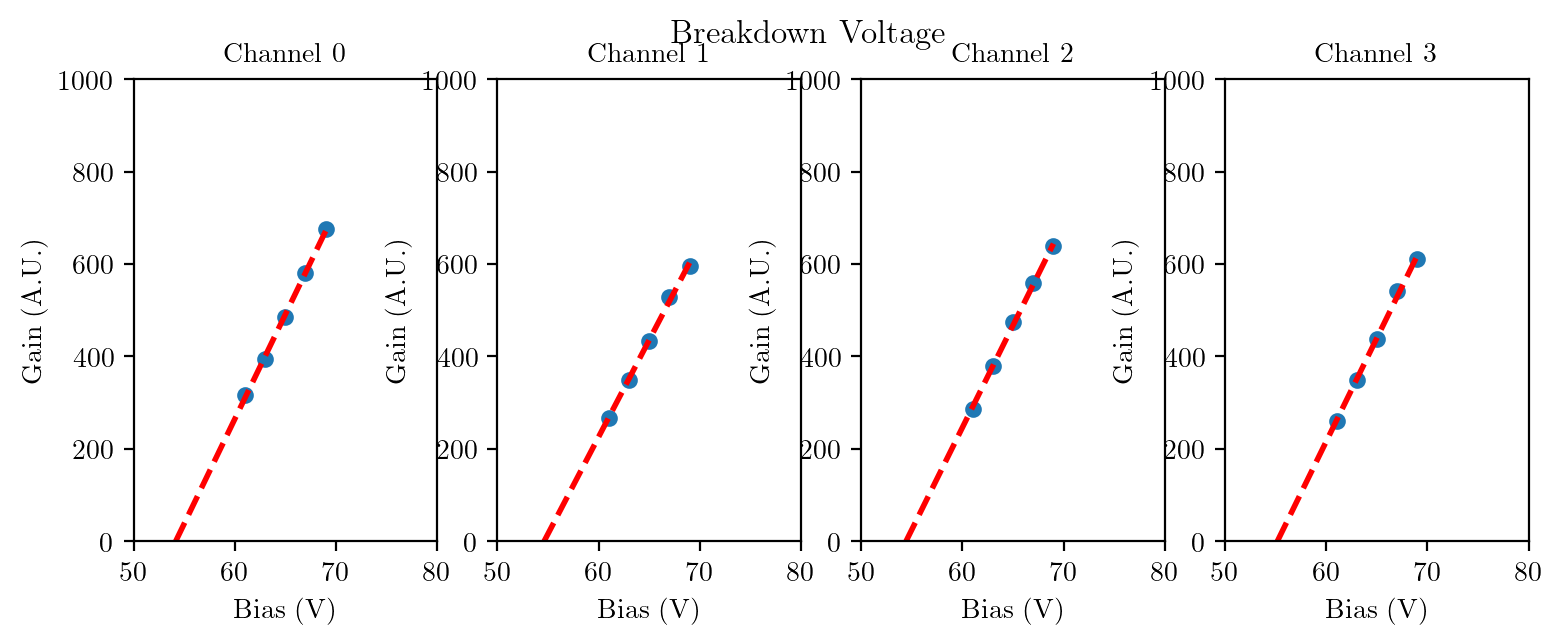

In [8]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
spe_range = np.zeros((4,5,2))
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_charge_bincent_ch_volt[ch][volt_id], h_charge_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 5000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 20 #threshold to remove baseline noise
        peaks,pdict = find_peaks(h_charge_ch_volt[ch][volt_id][thre:], prominence=60, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_charge_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_charge_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_charge_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
            if(ip==0):
                spe_range[ch,volt_id,:] = np.array([popt[1]-2*popt[2],popt[1]+2*popt[2]])
                print(spe_range[ch,volt_id,:])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

## Plot filtered amplitude histogram and analyze

Channel 0 Vbd=55.365+/-0.081V
Channel 1 Vbd=55.207+/-0.088V
Channel 2 Vbd=55.033+/-0.103V
Channel 3 Vbd=55.152+/-0.082V


Text(0.5, 0.98, 'Breakdown Voltage')

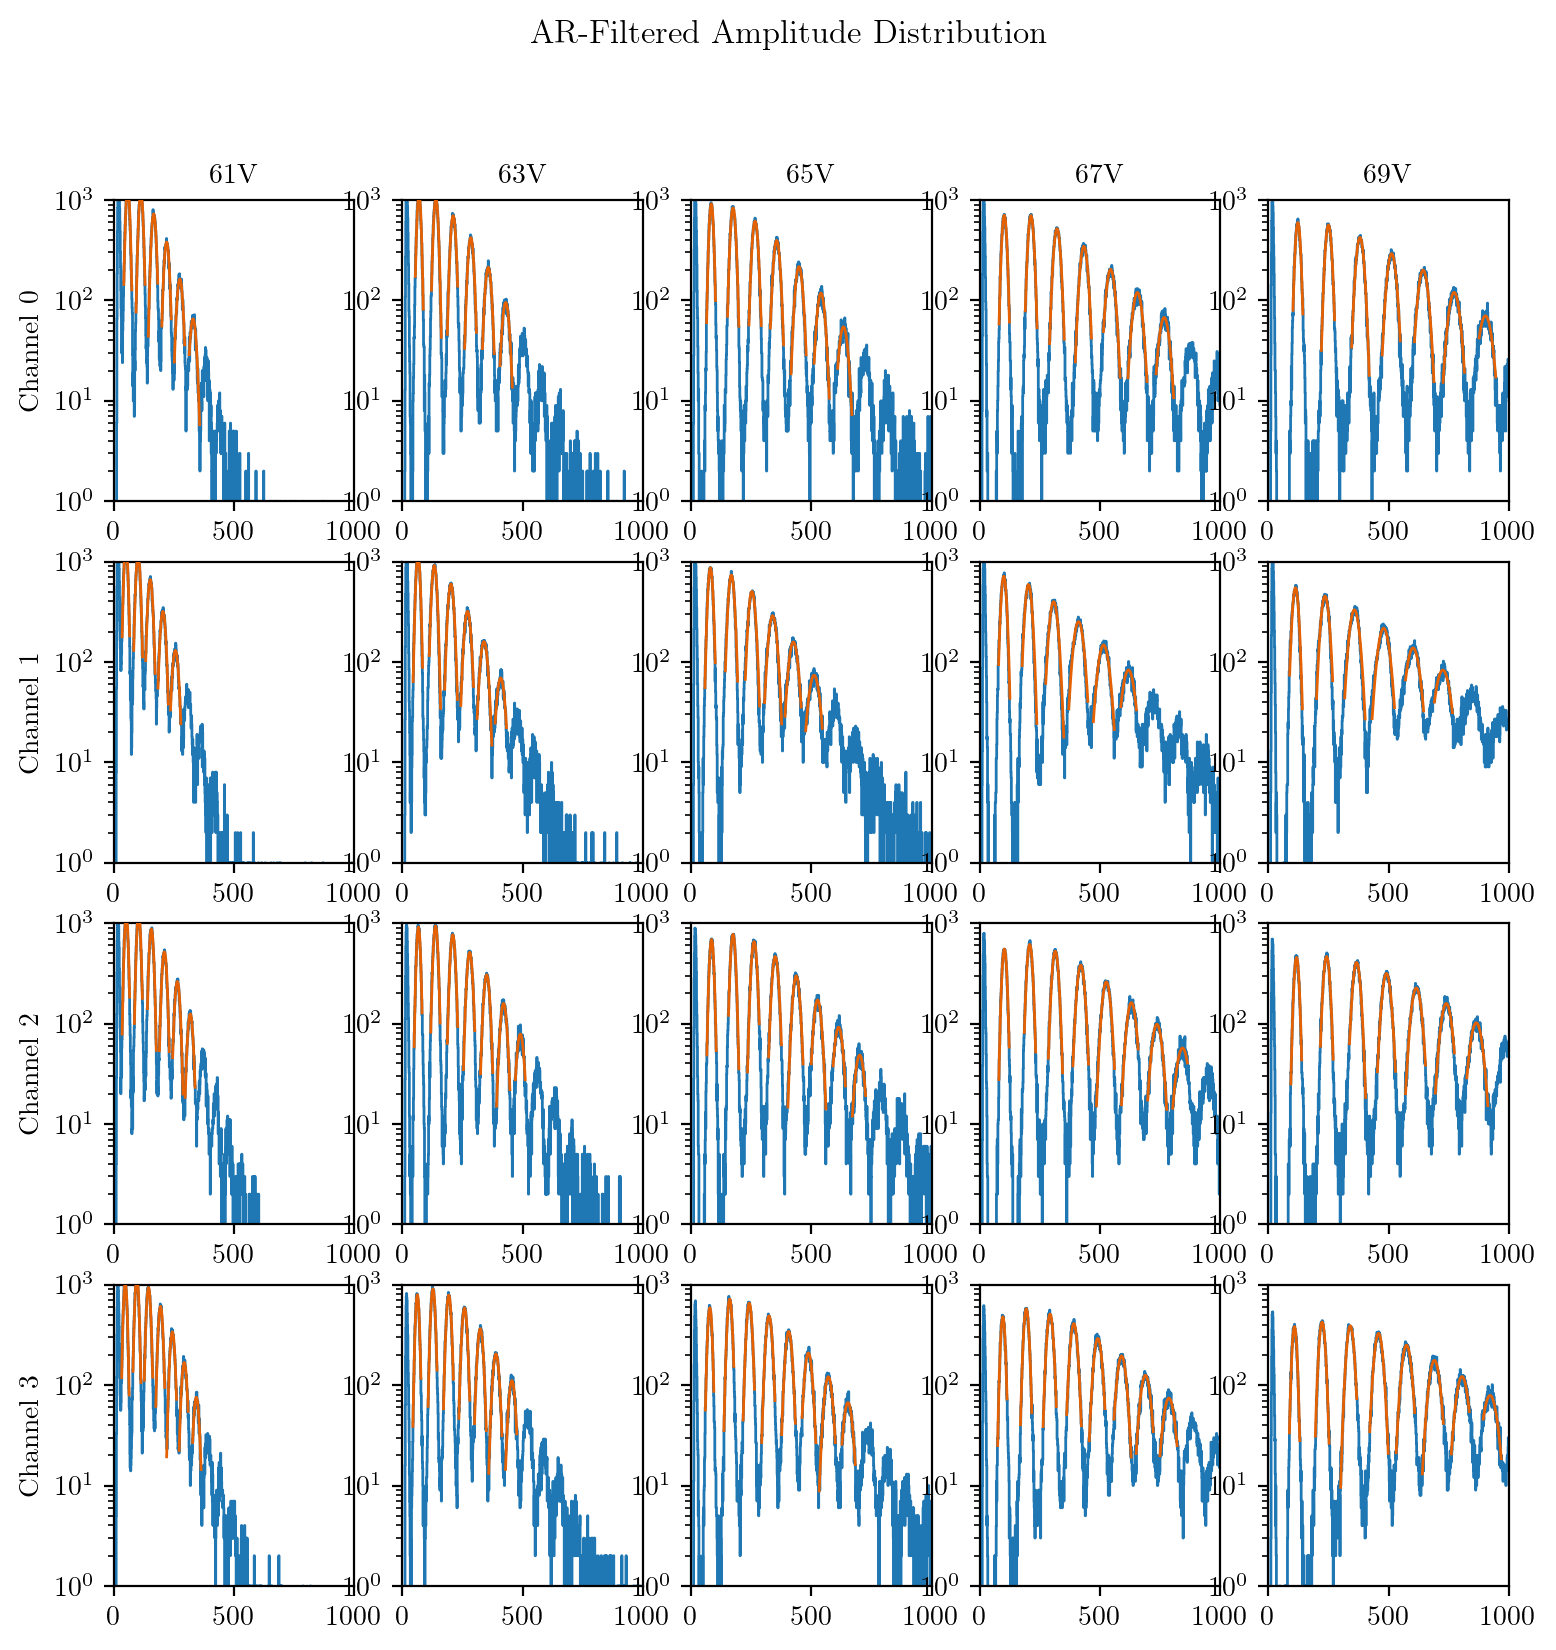

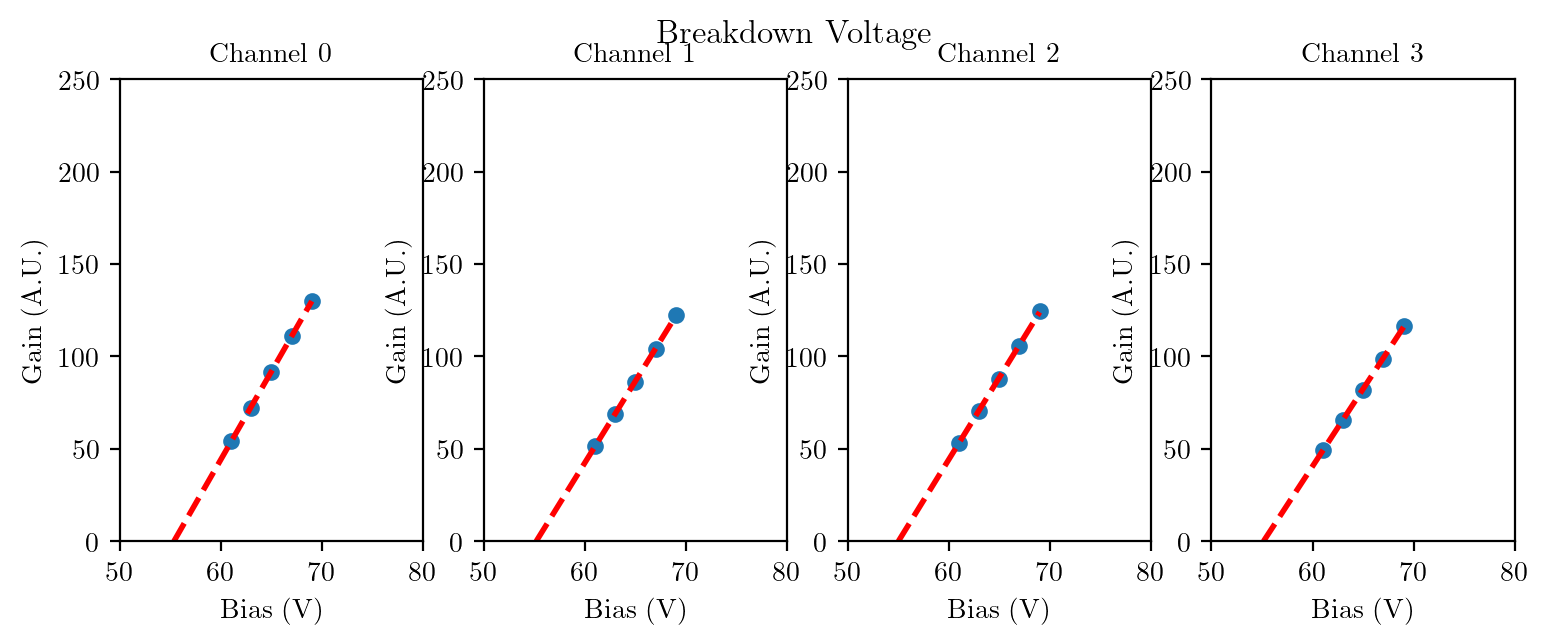

In [9]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_famp_bincent_ch_volt[ch][volt_id], h_famp_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_famp_ch_volt[ch][volt_id][30:], prominence=60, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_famp_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_famp_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_famp_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

## SPE average waveform

ch0 20220928_top_61V_laser_ext
  25268 waveforms averaged
  A1 = 4.016105407873746
  TAU1 = 103.98809636678425
  A2 = 64.93795636900826
  TAU2 = 17.98810043106205
ch0 20220928_top_63V_laser_ext
  20763 waveforms averaged
  A1 = 5.023722790377474
  TAU1 = 99.01037773694169
  A2 = 141.52541244222328
  TAU2 = 15.542964613271058
ch0 20220928_top_65V_laser_ext
  17900 waveforms averaged
  A1 = 7.298522367847721
  TAU1 = 86.48581345304679
  A2 = 322.1037671453414
  TAU2 = 13.422127922285185
ch0 20220928_top_67V_laser_ext
  15789 waveforms averaged
  A1 = 9.630659183255503
  TAU1 = 79.64675649246459
  A2 = 722.6149164230544
  TAU2 = 12.061173028823715
ch0 20220928_top_69V_laser_ext
  13961 waveforms averaged
  A1 = 12.623267868271697
  TAU1 = 72.92185985788018
  A2 = 407.9029555296443
  TAU2 = 13.881460971420402
ch1 20220928_top_61V_laser_ext
  29330 waveforms averaged
  A1 = 1.018461156382579
  TAU1 = 208.3710077201597
  A2 = 34.00761539813544
  TAU2 = 26.090859043690305
ch1 20220928_top_63V

/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


  19800 waveforms averaged
  A1 = 1.756120852241547
  TAU1 = 169.3172147543501
  A2 = 71.90831179577806
  TAU2 = 23.754472327889516
ch1 20220928_top_67V_laser_ext
  18015 waveforms averaged
  A1 = 2.0073267765525094
  TAU1 = 164.16776104863092
  A2 = 75.76248098204482
  TAU2 = 25.51626764078298
ch1 20220928_top_69V_laser_ext
  15573 waveforms averaged
  A1 = 2.9911789958681734
  TAU1 = 134.960081976341
  A2 = 108.73970920132344
  TAU2 = 23.120917316040543
ch2 20220928_top_61V_laser_ext
  22021 waveforms averaged
  A1 = 2.957021811645747
  TAU1 = 116.11231090404146
  A2 = 58.00711847538858
  TAU2 = 19.08883095870977
ch2 20220928_top_63V_laser_ext
  16711 waveforms averaged
  A1 = 4.319656054578538
  TAU1 = 103.62206586586576
  A2 = 117.53477286119528
  TAU2 = 16.66416913132714
ch2 20220928_top_65V_laser_ext
  13918 waveforms averaged
  A1 = 5.864776077406922
  TAU1 = 94.47726835569607
  A2 = 140.6536812923581
  TAU2 = 17.044091814407235
ch2 20220928_top_67V_laser_ext
  12218 waveforms a

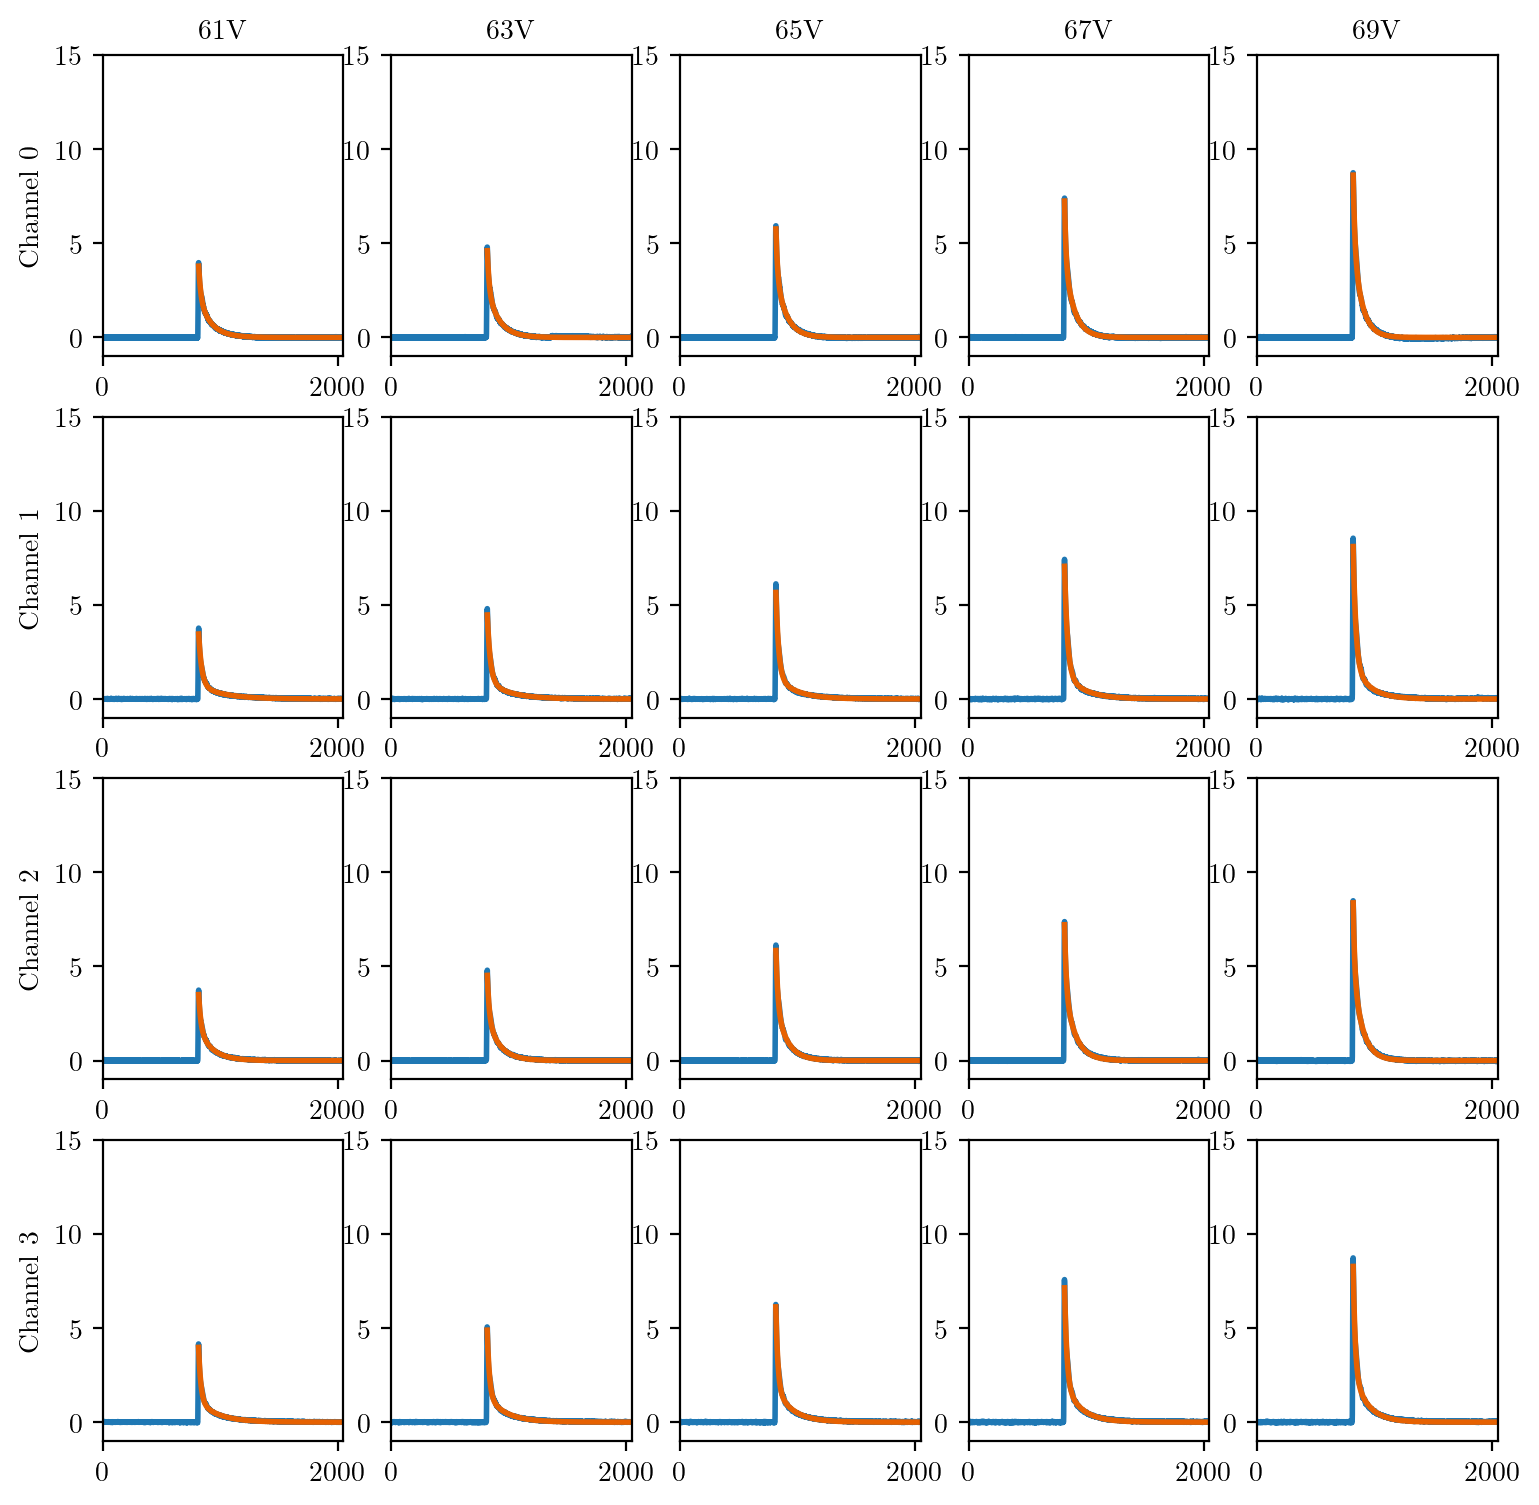

In [10]:
#spe average waveforms
spewf_ch_volt = np.zeros((4,5,length))
spewf_sample_ch_volt = np.zeros((4,5,length))
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,length)).astype(float)
        traces = np.tile(np.mean(traces[:,:bsl_length],axis=1).reshape(nevents,1),(1,length)) - traces
        integrals = np.sum(traces[:,tmin:tmax],axis=1)

        # spe average waveform
        count = 0
        for ievent,wf_sub_bsl in enumerate(traces):
            if integrals[ievent]<spe_range[ch][volt_id][1] and integrals[ievent]>spe_range[ch][volt_id][0]:
                spewf_ch_volt[ch][volt_id] = spewf_ch_volt[ch][volt_id]*count + wf_sub_bsl
                count += 1
                spewf_ch_volt[ch][volt_id] = spewf_ch_volt[ch][volt_id]/count
        trig_pos = np.argmax(spewf_ch_volt[ch][volt_id])
        print('  {} waveforms averaged'.format(count))
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(spewf_ch_volt[ch][volt_id])
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), spewf_ch_volt[ch][volt_id][trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  A1 = {}'.format(popt[0]))
        print('  TAU1 = {}'.format(popt[1]))
        print('  A2 = {}'.format(popt[2]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(-1, 15)

  A1 = 4.016105407873746
  TAU1 = 103.98809636678425
  A2 = 64.93795636900826
  TAU2 = 17.98810043106205
  A1 = 5.023722790377474
  TAU1 = 99.01037773694169
  A2 = 141.52541244222328
  TAU2 = 15.542964613271058
  A1 = 7.298522367847721
  TAU1 = 86.48581345304679
  A2 = 322.1037671453414
  TAU2 = 13.422127922285185
  A1 = 9.630659183255503
  TAU1 = 79.64675649246459
  A2 = 722.6149164230544
  TAU2 = 12.061173028823715
  A1 = 12.623267868271697
  TAU1 = 72.92185985788018
  A2 = 407.9029555296443
  TAU2 = 13.881460971420402
  A1 = 1.018461156382579
  TAU1 = 208.3710077201597
  A2 = 34.00761539813544
  TAU2 = 26.090859043690305
  A1 = 1.334674134539544
  TAU1 = 190.42260593080604
  A2 = 45.033714101837845
  TAU2 = 25.889515288927786
  A1 = 1.756120852241547
  TAU1 = 169.3172147543501
  A2 = 71.90831179577806
  TAU2 = 23.754472327889516
  A1 = 2.0073267765525094
  TAU1 = 164.16776104863092
  A2 = 75.76248098204482
  TAU2 = 25.51626764078298
  A1 = 2.9911789958681734
  TAU1 = 134.96008197634

/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


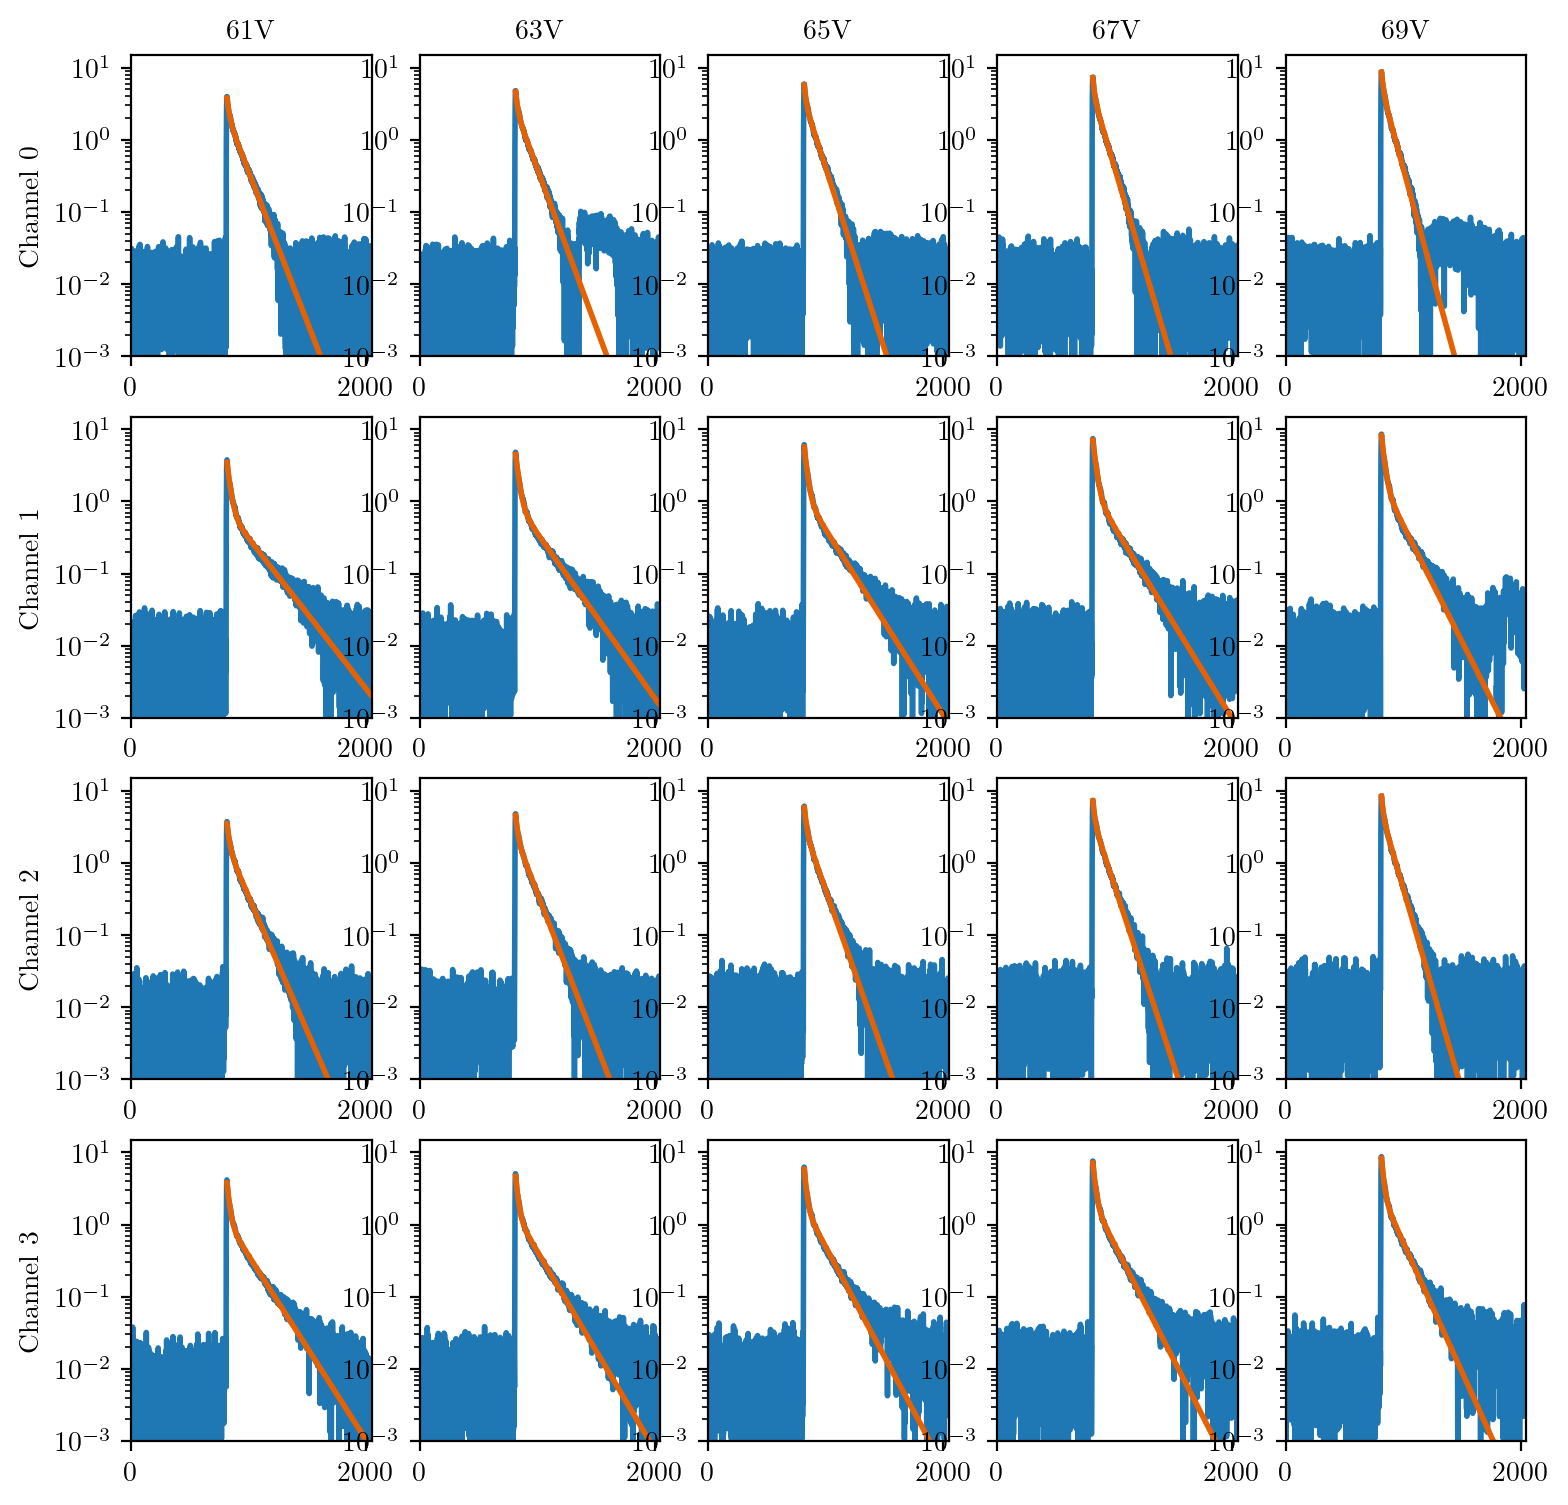

In [14]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(np.abs(spewf_ch_volt[ch][volt_id]))
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), spewf_ch_volt[ch][volt_id][trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  A1 = {}'.format(popt[0]))
        print('  TAU1 = {}'.format(popt[1]))
        print('  A2 = {}'.format(popt[2]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(1e-3, 15)
        plt.yscale('log')

# Bottome tile calibration (0928 data)

## Directories

In [15]:
voltages = ['20220928_bottom_61V_laser_ext',
            '20220928_bottom_63V_laser_ext',
            '20220928_bottom_65V_laser_ext',
            '20220928_bottom_67V_laser_ext',
            '20220928_bottom_69V_laser_ext']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

ch0 20220928_bottom_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch0 20220928_bottom_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch0 20220928_bottom_65V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch0 20220928_bottom_67V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch0 20220928_bottom_69V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch1 20220928_bottom_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch1 20220928_bottom_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch1 20220928_bottom_65V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch1 20220928_bottom_67V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch1 20220928_bottom_69V_laser_ext
  TRIGGER POSITION = SAMPLE 816
ch2 20220928_bottom_61V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_bottom_63V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_bottom_65V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_bottom_67V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch2 20220928_bottom_69V_laser_ext
  TRIGGER POSITION = SAMPLE 815
ch3 202209

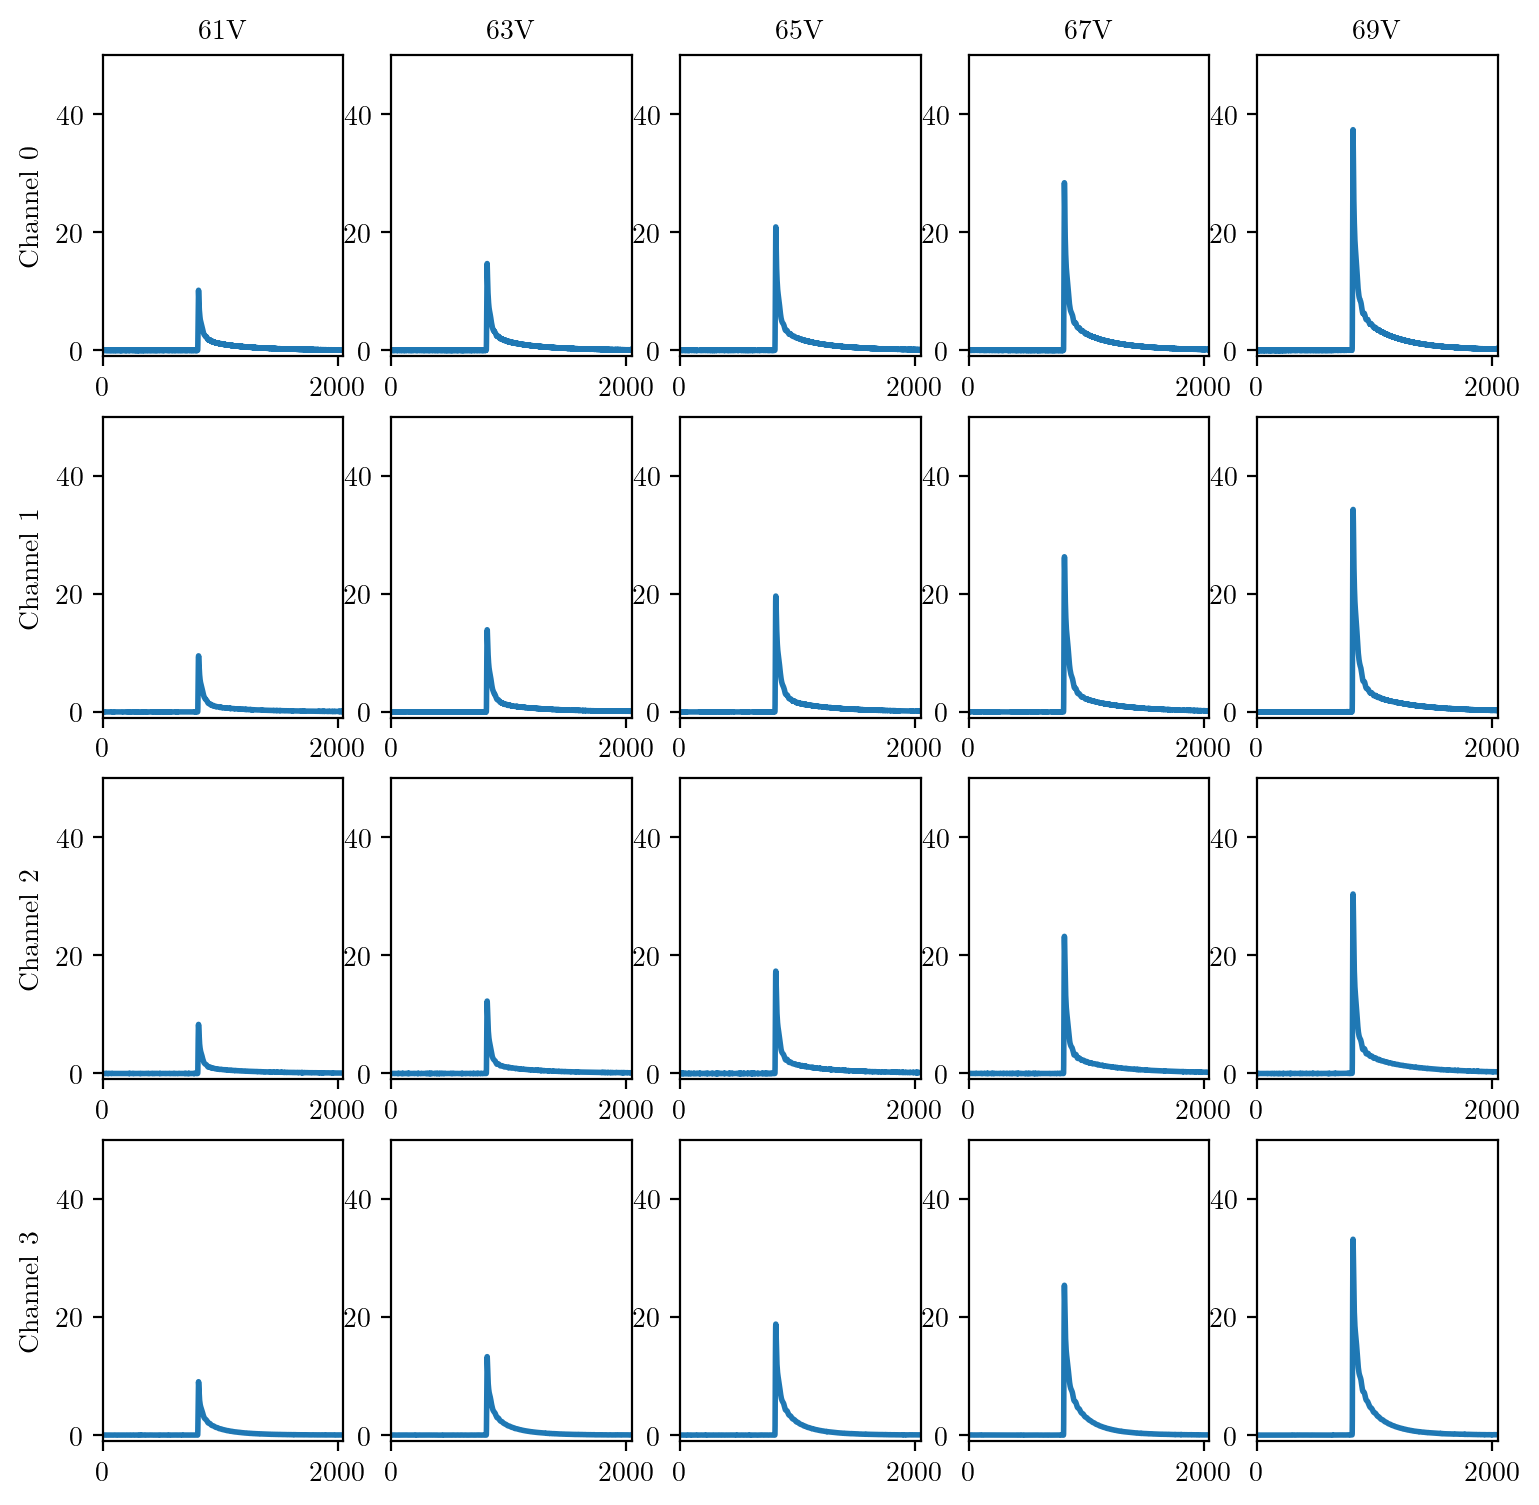

In [16]:
#waveform length in samples
length = 2048
#total events
nevents = 100000
#pretrigger baseline length
bsl_length = 800
#charge histogram
nbins_charge = 1000
h_charge_ch_volt = np.zeros((4,5,nbins_charge))
h_charge_bincent_ch_volt = np.zeros((4,5,nbins_charge))
h_charge_binwid_ch_volt = np.zeros((4,5))
#charge integral range
tmin = 800
tmax = 1200
#filtered amplitude histogram
nbins_famp = 1000
h_famp_ch_volt = np.zeros((4,5,nbins_famp))
h_famp_bincent_ch_volt = np.zeros((4,5,nbins_famp))
h_famp_binwid_ch_volt = np.zeros((4,5))
#AR time constant
tau = 20
#average waveform
avgwf_ch_volt = np.zeros((4,5,length))
avgwf_sample_ch_volt = np.zeros((4,5,length))
#for average waveforms
plt.figure(0,figsize=(9,9))
# bias voltage
bias = [61, 63, 65, 67, 69]

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,length)).astype(float)
        traces = np.tile(np.mean(traces[:,:bsl_length],axis=1).reshape(nevents,1),(1,length)) - traces
        integrals = np.sum(traces[:,tmin:tmax],axis=1)
        amps_filt = np.max(AR_filter(traces, tau),axis=1)
        
        #charge histogram
        h_charge_ch_volt[ch][volt_id], bin_edges = np.histogram(integrals, bins=np.linspace(0, 5000, nbins_charge+1))#linspace(min, max, nbins+1)
        h_charge_bincent_ch_volt[ch][volt_id] = (bin_edges[1:]+bin_edges[:-1])/2
        h_charge_binwid_ch_volt[ch][volt_id] = bin_edges[1]-bin_edges[0]

        #filtered amplitude histogram
        h_famp_ch_volt[ch][volt_id], bin_edges = np.histogram(amps_filt, bins=np.linspace(0, 1000, nbins_famp+1))#linspace(min, max, nbins+1)
        h_famp_bincent_ch_volt[ch][volt_id] = (bin_edges[1:]+bin_edges[:-1])/2
        h_famp_binwid_ch_volt[ch][volt_id] = bin_edges[1]-bin_edges[0]

        # spe average waveform
        # not implemented yet. for now average over all waveforms
        count = 0
        meanwf = np.mean(traces,axis=0)
        for wf_sub_bsl in traces:
            avgwf_ch_volt[ch][volt_id] = avgwf_ch_volt[ch][volt_id]*count + wf_sub_bsl
            count += 1
            avgwf_ch_volt[ch][volt_id] = avgwf_ch_volt[ch][volt_id]/count
        trig_pos = np.argmax(avgwf_ch_volt[ch][volt_id])
        print('  TRIGGER POSITION = SAMPLE {}'.format(trig_pos))
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        plt.xlim(0,2048)
        plt.ylim(-1, 50)

## Plot charge histogram and analyze

[ 58.7050286  382.34923391]
[110.72184634 397.62634245]
[154.0963365  456.04626004]
[190.66986861 521.46207579]
[216.07429475 613.09697376]
Channel 0 Vbd=54.592+/-0.340V
[ -4.37730673 413.08618245]
[ 39.73177401 471.7840036 ]
[ 87.8865003  522.40548417]
[117.81414455 622.10059878]
[117.72682928 681.08183723]
Channel 1 Vbd=54.987+/-0.307V
[ -5.32917406 366.75439811]
[ 51.62943642 400.50703643]
[ 97.668135   444.98545493]
[120.57302869 529.40292133]
[137.65381429 581.42336637]
Channel 2 Vbd=55.356+/-0.219V
[ 68.86892555 388.27189753]
[131.1452703  452.62696603]
[173.39941382 529.6858256 ]
[214.15089808 627.82388876]
[229.18859931 688.08130593]
Channel 3 Vbd=54.992+/-0.040V


Text(0.5, 0.98, 'Breakdown Voltage')

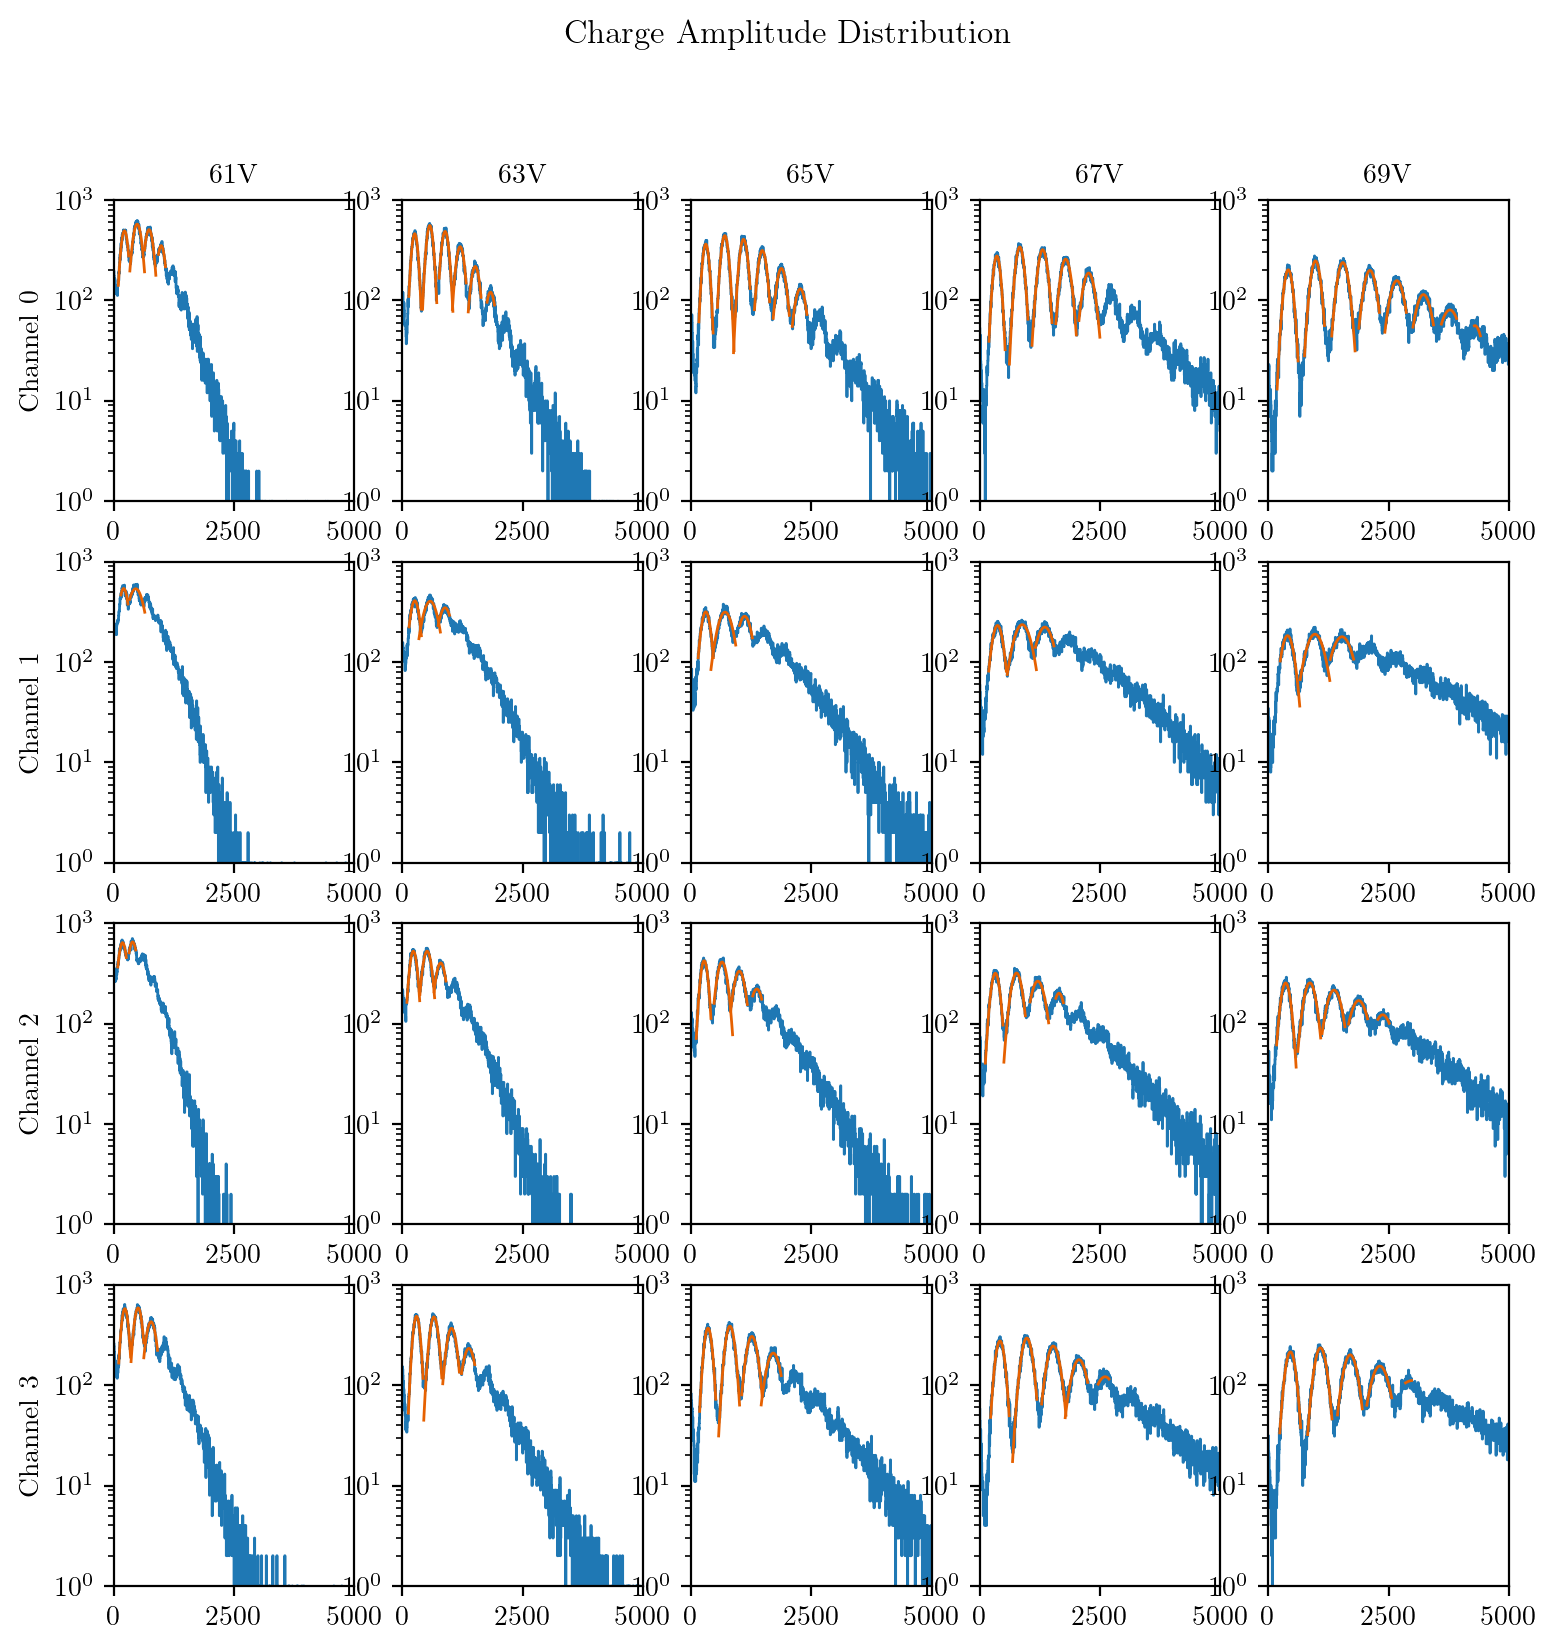

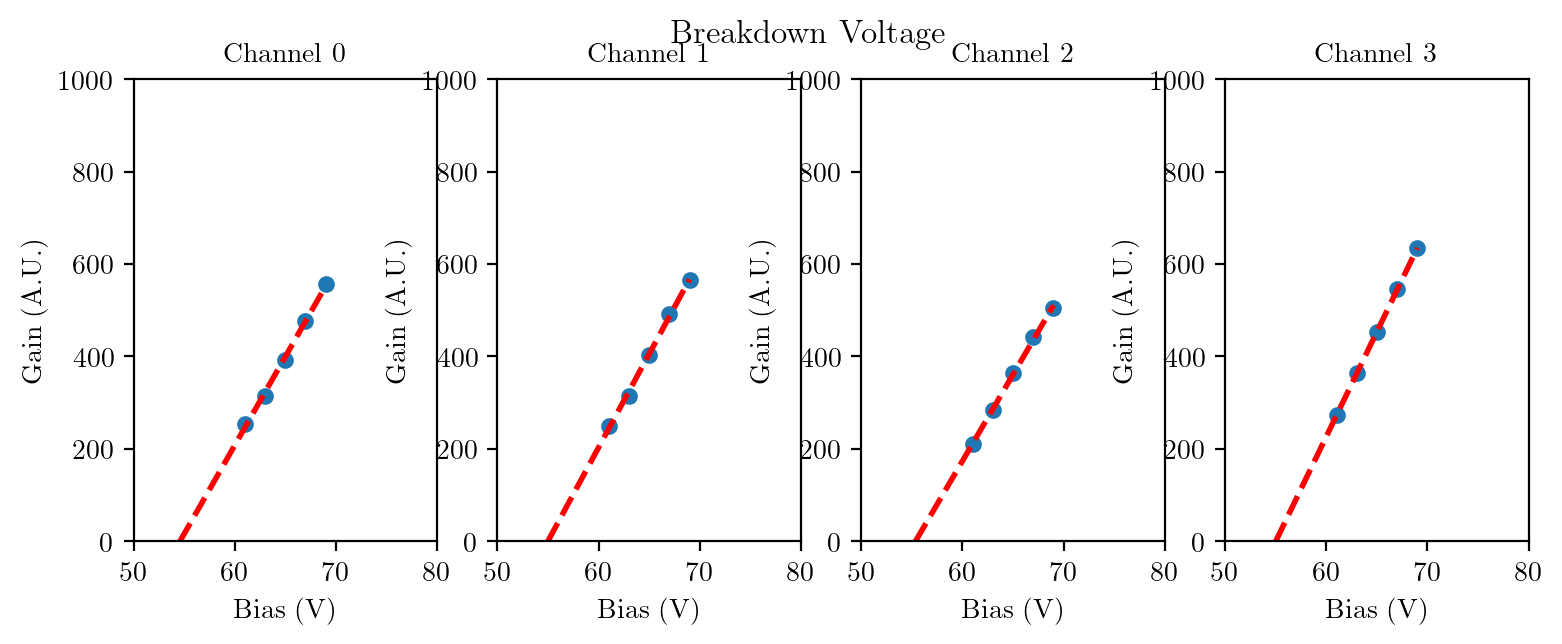

In [25]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
spe_range = np.zeros((4,5,2))
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_charge_bincent_ch_volt[ch][volt_id], h_charge_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 5000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 20 #threshold to remove baseline noise
        peaks,pdict = find_peaks(h_charge_ch_volt[ch][volt_id][thre:], prominence=35, width=13, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_charge_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_charge_bincent_ch_volt[ch][volt_id][0] + h_charge_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_charge_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_charge_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_charge_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
            if(ip==0):
                spe_range[ch,volt_id,:] = np.array([popt[1]-2*popt[2],popt[1]+2*popt[2]])
                print(spe_range[ch,volt_id,:])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

## Plot filtered amplitude histogram and analyze

It seems like Ch1 has double peaks...

Channel 0 Vbd=55.275+/-0.071V
Channel 1 Vbd=55.451+/-0.151V
Channel 2 Vbd=55.035+/-0.109V
Channel 3 Vbd=55.225+/-0.161V


Text(0.5, 0.98, 'Breakdown Voltage')

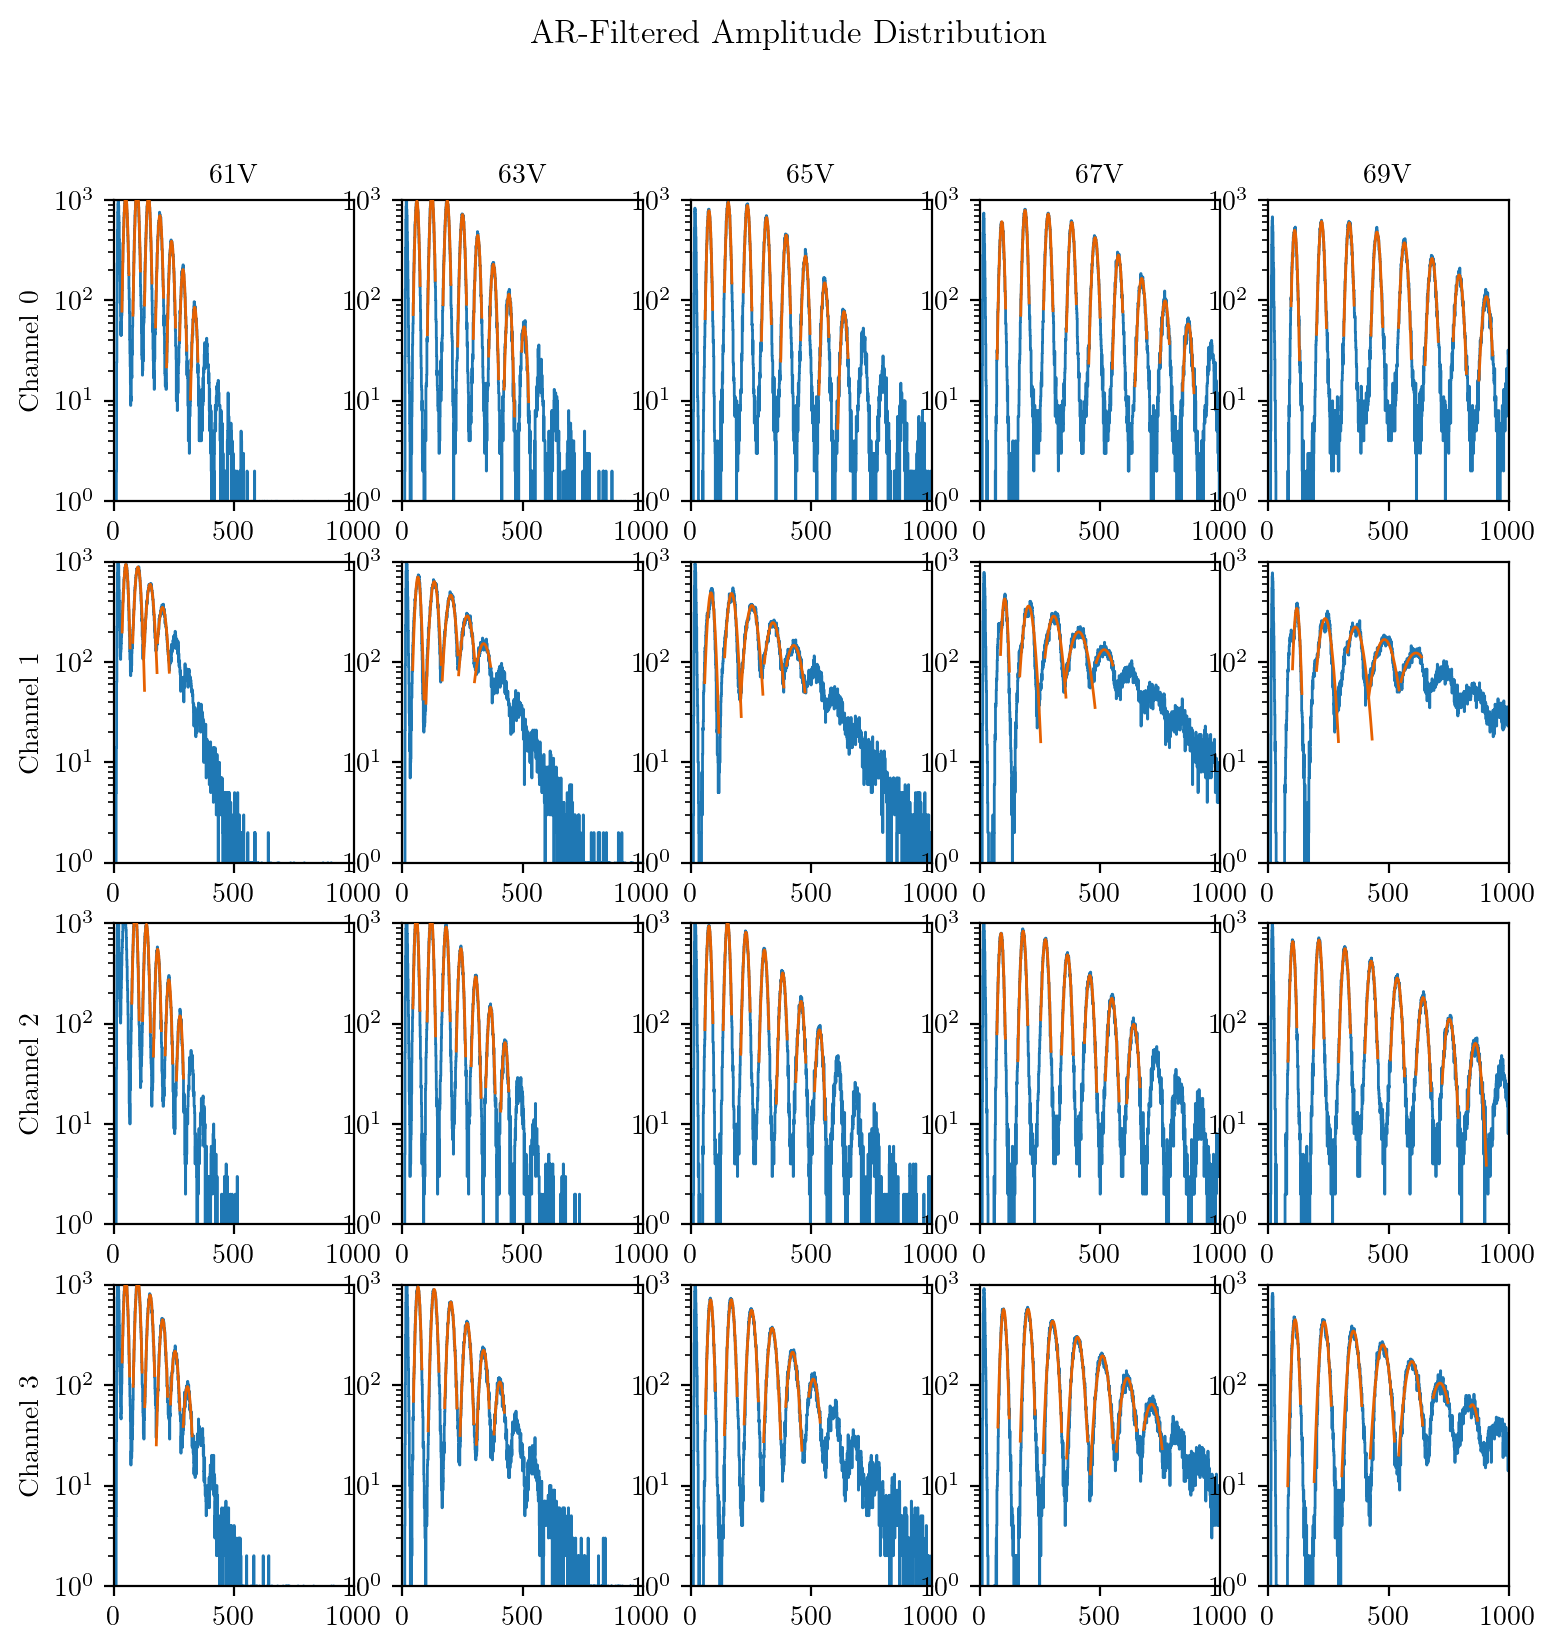

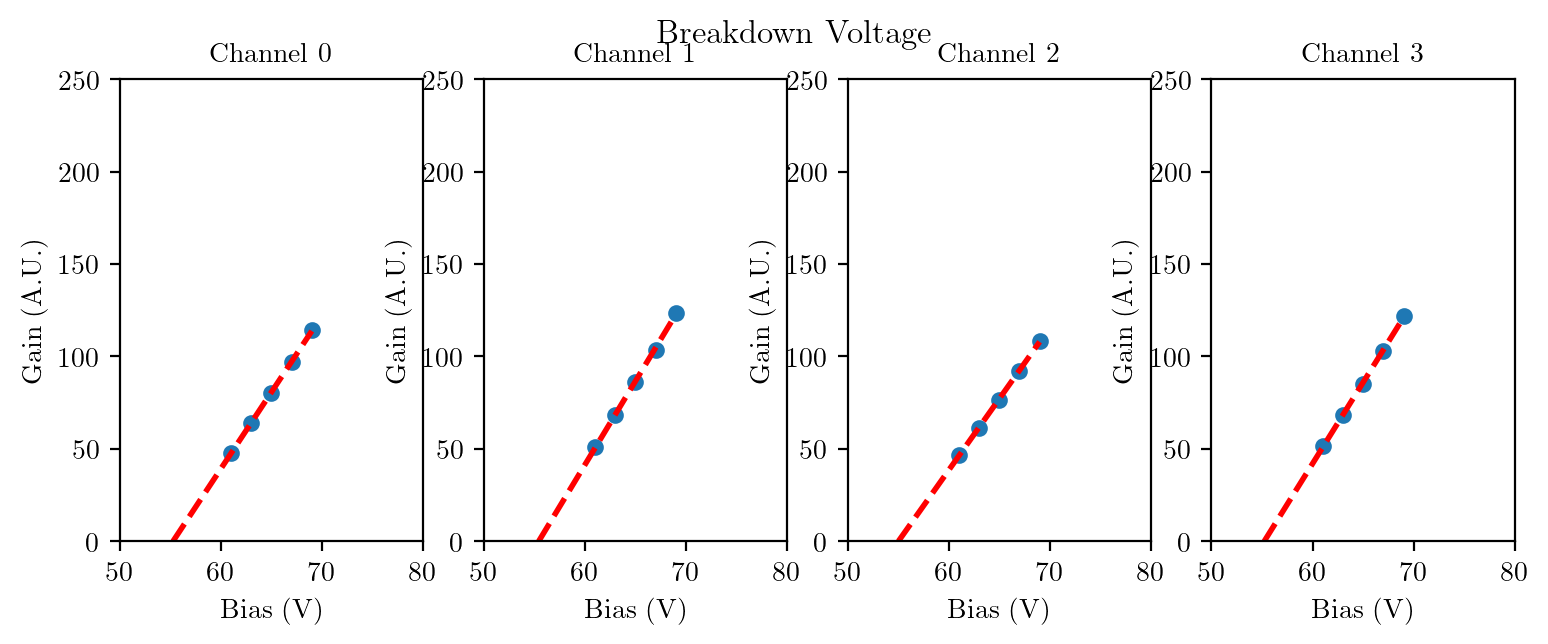

In [26]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_famp_bincent_ch_volt[ch][volt_id], h_famp_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_famp_ch_volt[ch][volt_id][30:], prominence=60, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_famp_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_famp_bincent_ch_volt[ch][volt_id][0] + h_famp_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_famp_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_famp_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_famp_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

## SPE average waveform

ch0 20220928_bottom_61V_laser_ext
  20923 waveforms averaged
  A1 = 8.26413418137396
  TAU1 = 60.921967909656736
  A2 = -21.176052418156
  TAU2 = 1.749459431624301
ch0 20220928_bottom_63V_laser_ext


/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


  15938 waveforms averaged
  A1 = 11.410703471024114
  TAU1 = 53.72102757372956
  A2 = -15.542170591836928
  TAU2 = 0.7370806231054767
ch0 20220928_bottom_65V_laser_ext
  13114 waveforms averaged
  A1 = 1.4453696159551819
  TAU1 = 222.58609073854984
  A2 = 121.49565807300058
  TAU2 = 19.67349768381452
ch0 20220928_bottom_67V_laser_ext
  10959 waveforms averaged
  A1 = 1.760605752162826
  TAU1 = 206.27436089118368
  A2 = 179.8293319236598
  TAU2 = 18.841825766502517
ch0 20220928_bottom_69V_laser_ext
  9552 waveforms averaged
  A1 = 2.0765683168107025
  TAU1 = 192.74744269990677
  A2 = 166.50731536544885
  TAU2 = 20.29813789934257
ch1 20220928_bottom_61V_laser_ext
  33321 waveforms averaged
  A1 = 15.999194935122063
  TAU1 = 44.324185336686
  A2 = -15.556511992559415
  TAU2 = 2.549806917551048
ch1 20220928_bottom_63V_laser_ext
  23278 waveforms averaged
  A1 = 0.761933690442055
  TAU1 = 319.15571287702556
  A2 = 62.32060065059612
  TAU2 = 25.102950790461378
ch1 20220928_bottom_65V_laser_

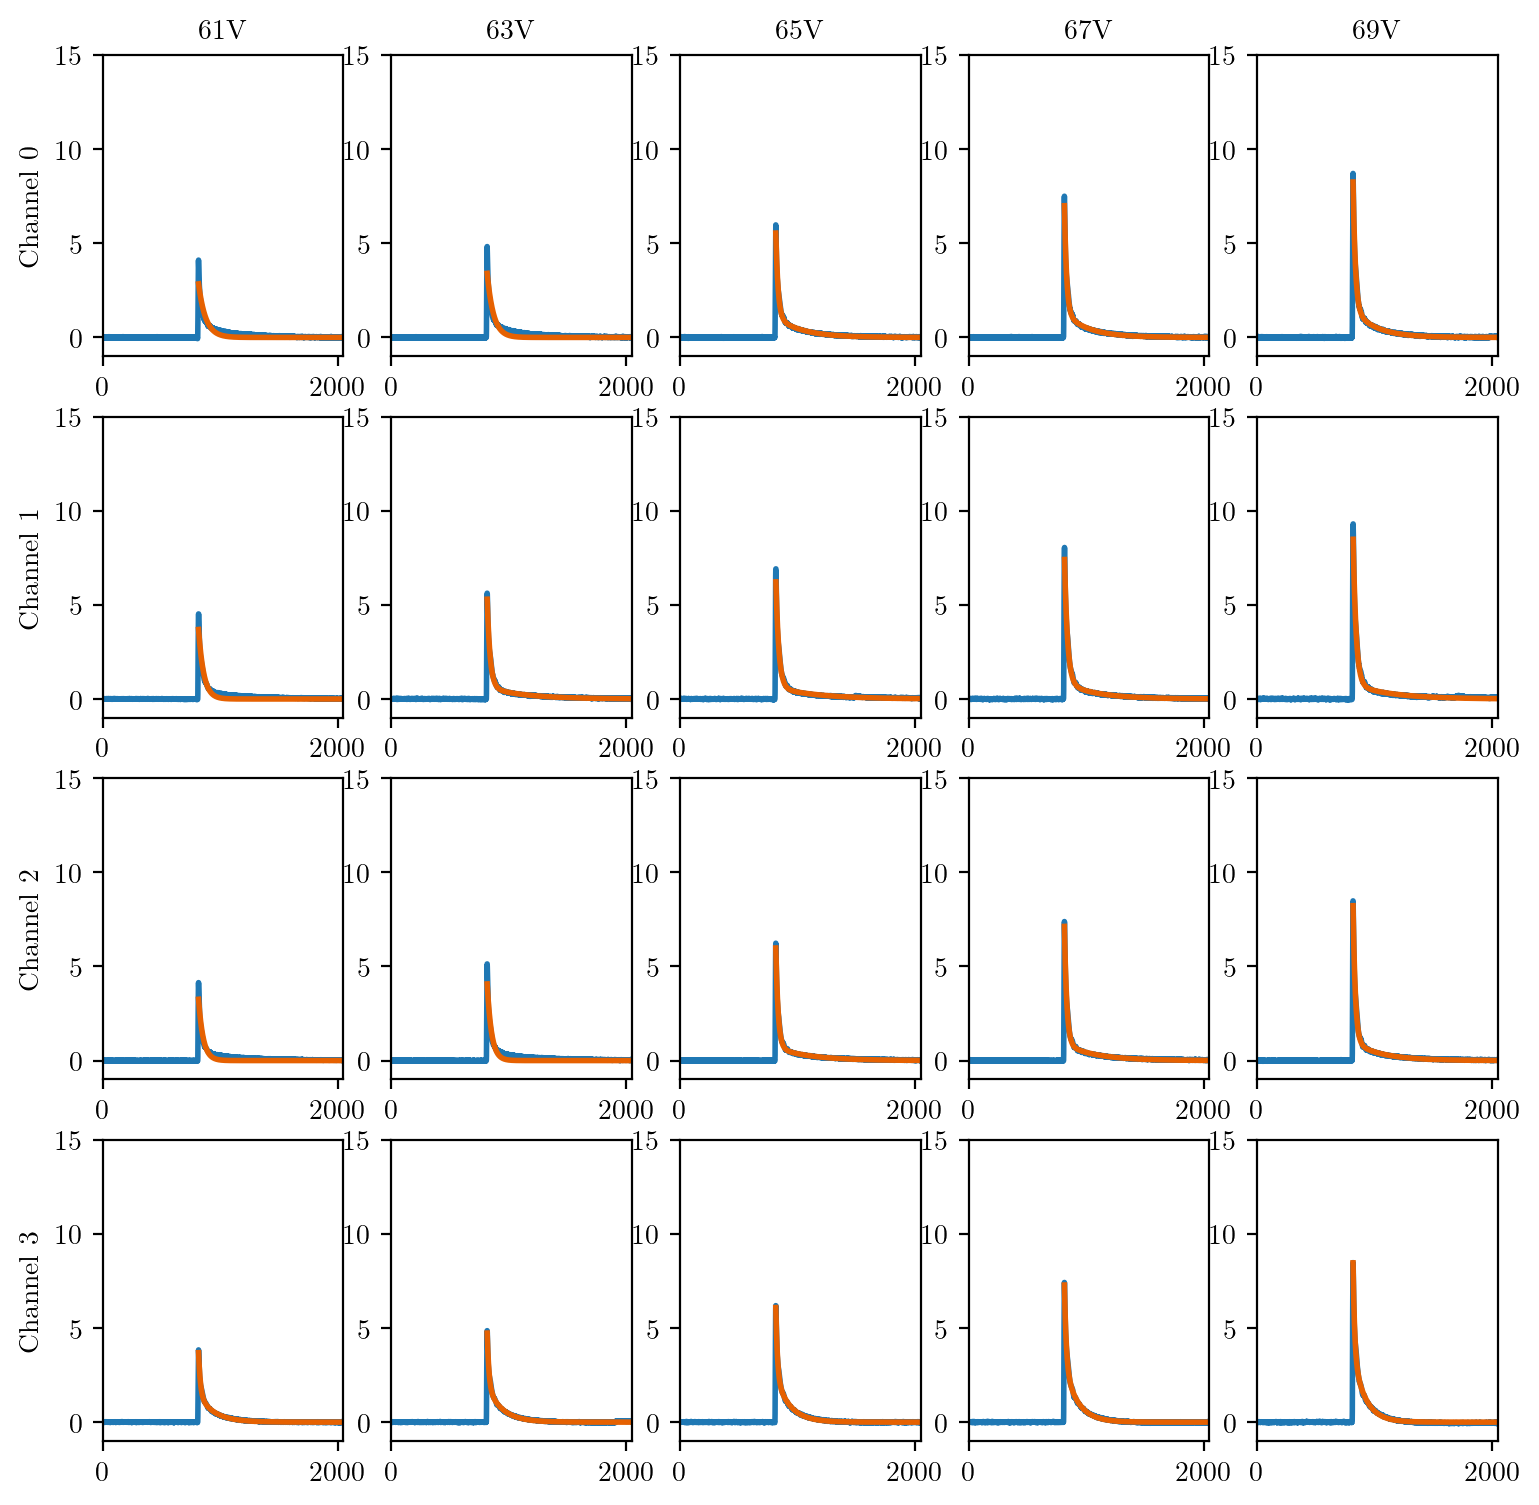

In [27]:
#spe average waveforms
spewf_ch_volt = np.zeros((4,5,length))
spewf_sample_ch_volt = np.zeros((4,5,length))
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,length)).astype(float)
        traces = np.tile(np.mean(traces[:,:bsl_length],axis=1).reshape(nevents,1),(1,length)) - traces
        integrals = np.sum(traces[:,tmin:tmax],axis=1)

        # spe average waveform
        count = 0
        for ievent,wf_sub_bsl in enumerate(traces):
            if integrals[ievent]<spe_range[ch][volt_id][1] and integrals[ievent]>spe_range[ch][volt_id][0]:
                spewf_ch_volt[ch][volt_id] = spewf_ch_volt[ch][volt_id]*count + wf_sub_bsl
                count += 1
                spewf_ch_volt[ch][volt_id] = spewf_ch_volt[ch][volt_id]/count
        trig_pos = np.argmax(spewf_ch_volt[ch][volt_id])
        print('  {} waveforms averaged'.format(count))
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(spewf_ch_volt[ch][volt_id])
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), spewf_ch_volt[ch][volt_id][trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  A1 = {}'.format(popt[0]))
        print('  TAU1 = {}'.format(popt[1]))
        print('  A2 = {}'.format(popt[2]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(-1, 15)

  A1 = 4.016105407873746
  TAU1 = 103.98809636678425
  A2 = 64.93795636900826
  TAU2 = 17.98810043106205
  A1 = 5.023722790377474
  TAU1 = 99.01037773694169
  A2 = 141.52541244222328
  TAU2 = 15.542964613271058
  A1 = 7.298522367847721
  TAU1 = 86.48581345304679
  A2 = 322.1037671453414
  TAU2 = 13.422127922285185
  A1 = 9.630659183255503
  TAU1 = 79.64675649246459
  A2 = 722.6149164230544
  TAU2 = 12.061173028823715
  A1 = 12.623267868271697
  TAU1 = 72.92185985788018
  A2 = 407.9029555296443
  TAU2 = 13.881460971420402
  A1 = 1.018461156382579
  TAU1 = 208.3710077201597
  A2 = 34.00761539813544
  TAU2 = 26.090859043690305
  A1 = 1.334674134539544
  TAU1 = 190.42260593080604
  A2 = 45.033714101837845
  TAU2 = 25.889515288927786
  A1 = 1.756120852241547
  TAU1 = 169.3172147543501
  A2 = 71.90831179577806
  TAU2 = 23.754472327889516
  A1 = 2.0073267765525094
  TAU1 = 164.16776104863092
  A2 = 75.76248098204482
  TAU2 = 25.51626764078298
  A1 = 2.9911789958681734
  TAU1 = 134.96008197634

/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2882860/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


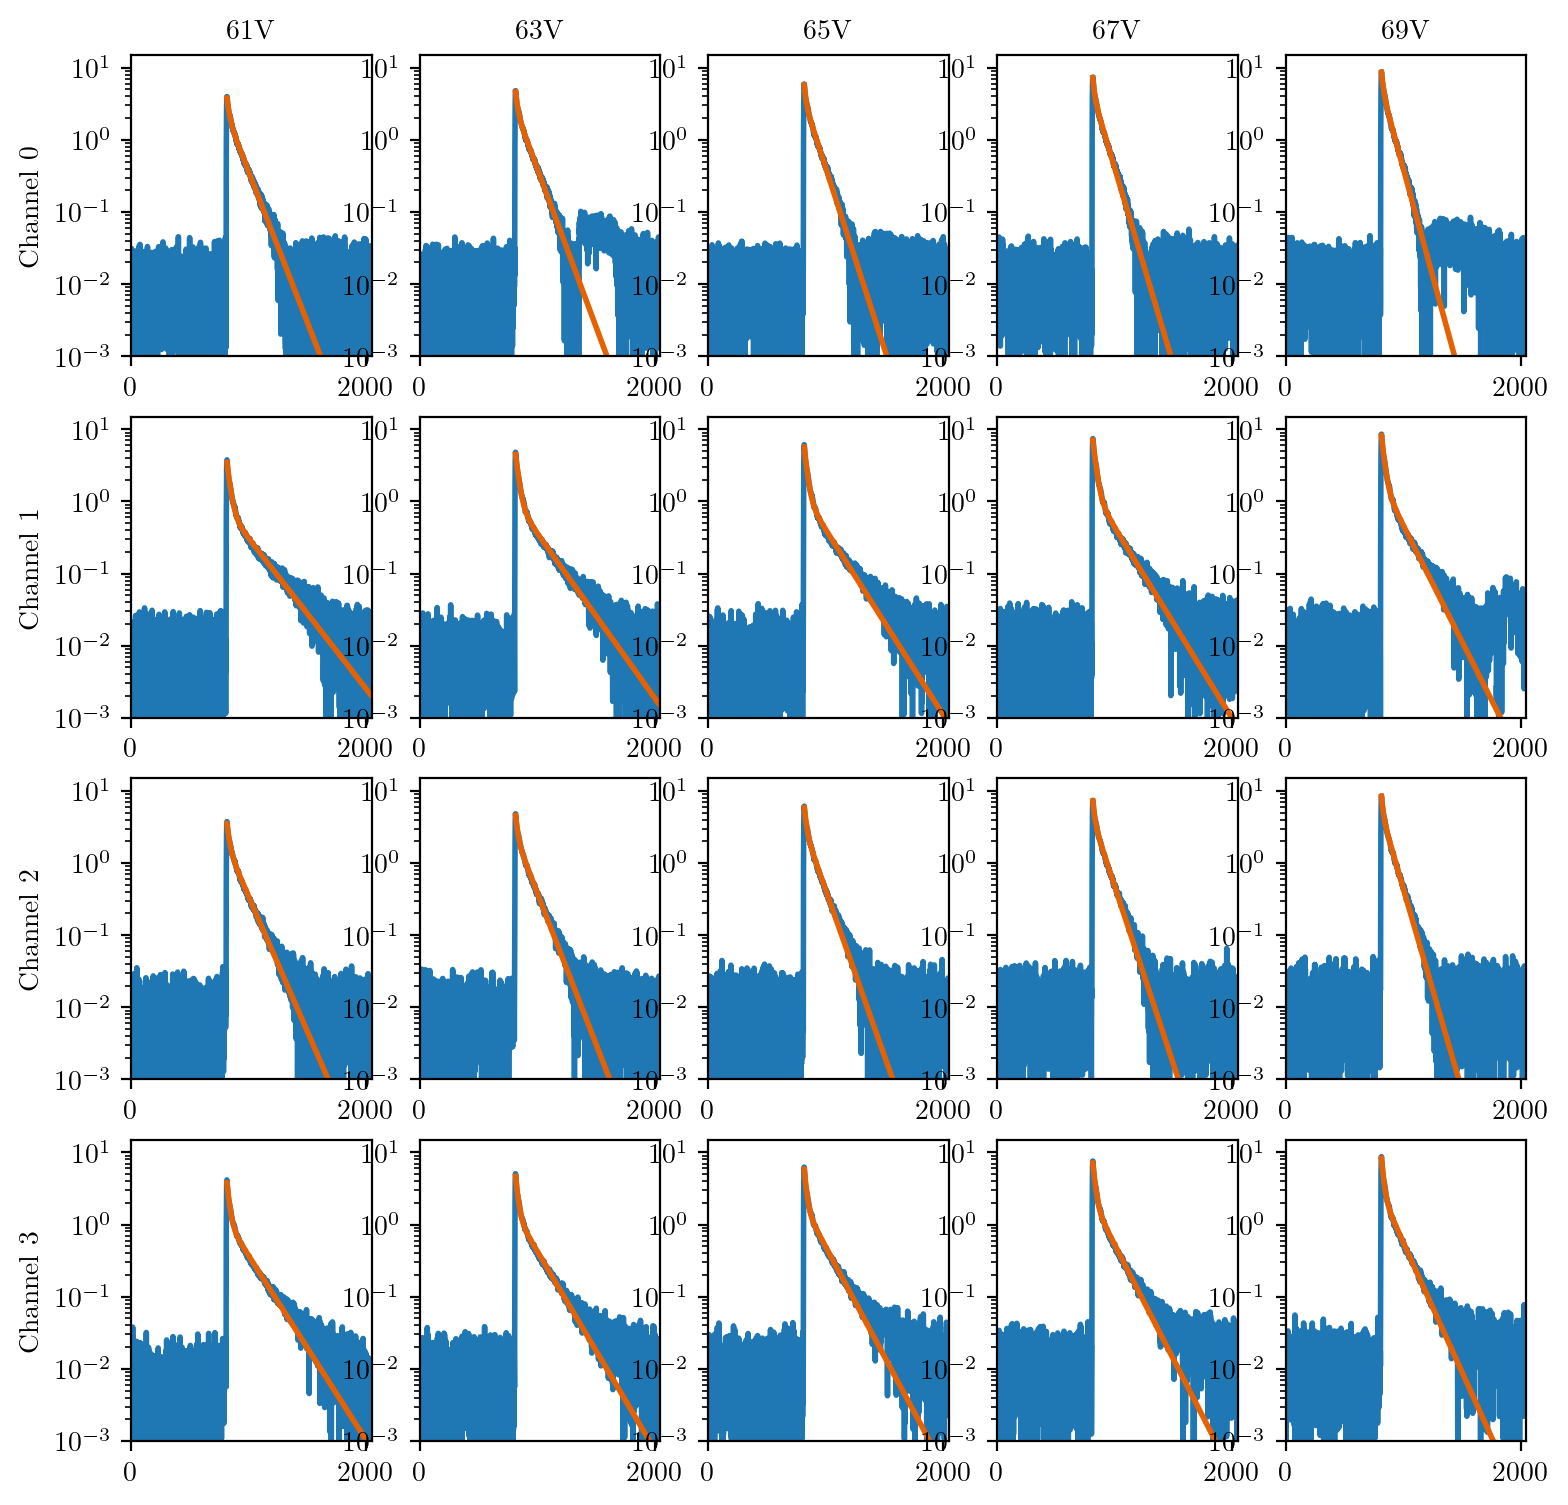

In [14]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(np.abs(spewf_ch_volt[ch][volt_id]))
        popt,pcov = curve_fit(expo_pulse, np.linspace(trig_pos,2047,2048-trig_pos), spewf_ch_volt[ch][volt_id][trig_pos:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(trig_pos,2047,2048-trig_pos), expo_pulse(np.linspace(trig_pos,2047,2048-trig_pos),*popt))
        print('  A1 = {}'.format(popt[0]))
        print('  TAU1 = {}'.format(popt[1]))
        print('  A2 = {}'.format(popt[2]))
        print('  TAU2 = {}'.format(popt[3]))
        plt.xlim(0,2048)
        plt.ylim(1e-3, 15)
        plt.yscale('log')

# Top tile directories (0923 data)

In [9]:
voltages = ['20220923_60V_laser_3725thres',
            '20220923_61V_laser_3722thres',
            '20220923_62V_laser_3722thres',
            '20220923_63V_laser_3720thres',
            '20220923_64V_laser_3718thres']

## Charge finger plot and average waveform
The charge finger plots have bad resolution for bias below 62V.
Average waveforms show the trigger position at sample 750 ($3\rm\mu s$)

ch0 20220923_60V_laser_3725thres
[  2.63703731 212.3232396    7.79036538  45.20076636]
ch0 20220923_61V_laser_3722thres
[  3.89994286 207.35304062  11.81357083  47.23710143]
ch0 20220923_62V_laser_3722thres
[  3.72223608 209.09923876  10.59237098  50.28803188]
ch0 20220923_63V_laser_3720thres
[  5.88113761 197.4967432   15.30454142  43.27409166]
ch0 20220923_64V_laser_3718thres
[  6.14682949 215.32436876  19.44528753  45.0730793 ]
ch1 20220923_60V_laser_3725thres
[  2.10076578 260.40656356   8.57939321  36.40631775]
ch1 20220923_61V_laser_3722thres
[  3.59448403 247.67959891  14.47469951  33.72951385]
ch1 20220923_62V_laser_3722thres
[  3.31744749 263.5541422   14.35095177  35.57853957]
ch1 20220923_63V_laser_3720thres
[  4.74384702 244.12138418  21.04234476  34.02201124]
ch1 20220923_64V_laser_3718thres
[  5.78707498 251.19517714  26.10210722  34.218954  ]
ch2 20220923_60V_laser_3725thres
[  1.21992136 304.55500812   7.88483357  36.24695877]
ch2 20220923_61V_laser_3722thres


/tmp/ipykernel_2498319/1876235883.py:11: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)
/tmp/ipykernel_2498319/1876235883.py:11: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-(x-750)/tau1)+a2*np.exp(-(x-750)/tau2)


[  5.01223866 140.67390945 -28.77916916   1.97046406]
ch2 20220923_62V_laser_3722thres
[  5.02697467 140.21454648  -2.82535316   0.21321879]
ch2 20220923_63V_laser_3720thres
[  2.72083456 281.04931629  18.2264696   35.42339639]
ch2 20220923_64V_laser_3718thres
[  3.23741106 293.7248516   21.77382639  36.34734463]
ch3 20220923_60V_laser_3725thres
[  2.76604267 163.98838171   6.14031989  32.344673  ]
ch3 20220923_61V_laser_3722thres
[  7.00425606 117.05352562  -8.78318911   1.71826472]
ch3 20220923_62V_laser_3722thres
[  4.53276407 158.84196464  10.28309411  32.99952686]
ch3 20220923_63V_laser_3720thres
[  6.34524749 156.32211568  14.67526533  32.73361454]
ch3 20220923_64V_laser_3718thres
[  7.33008588 162.1660496   17.51275732  34.96890078]


Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

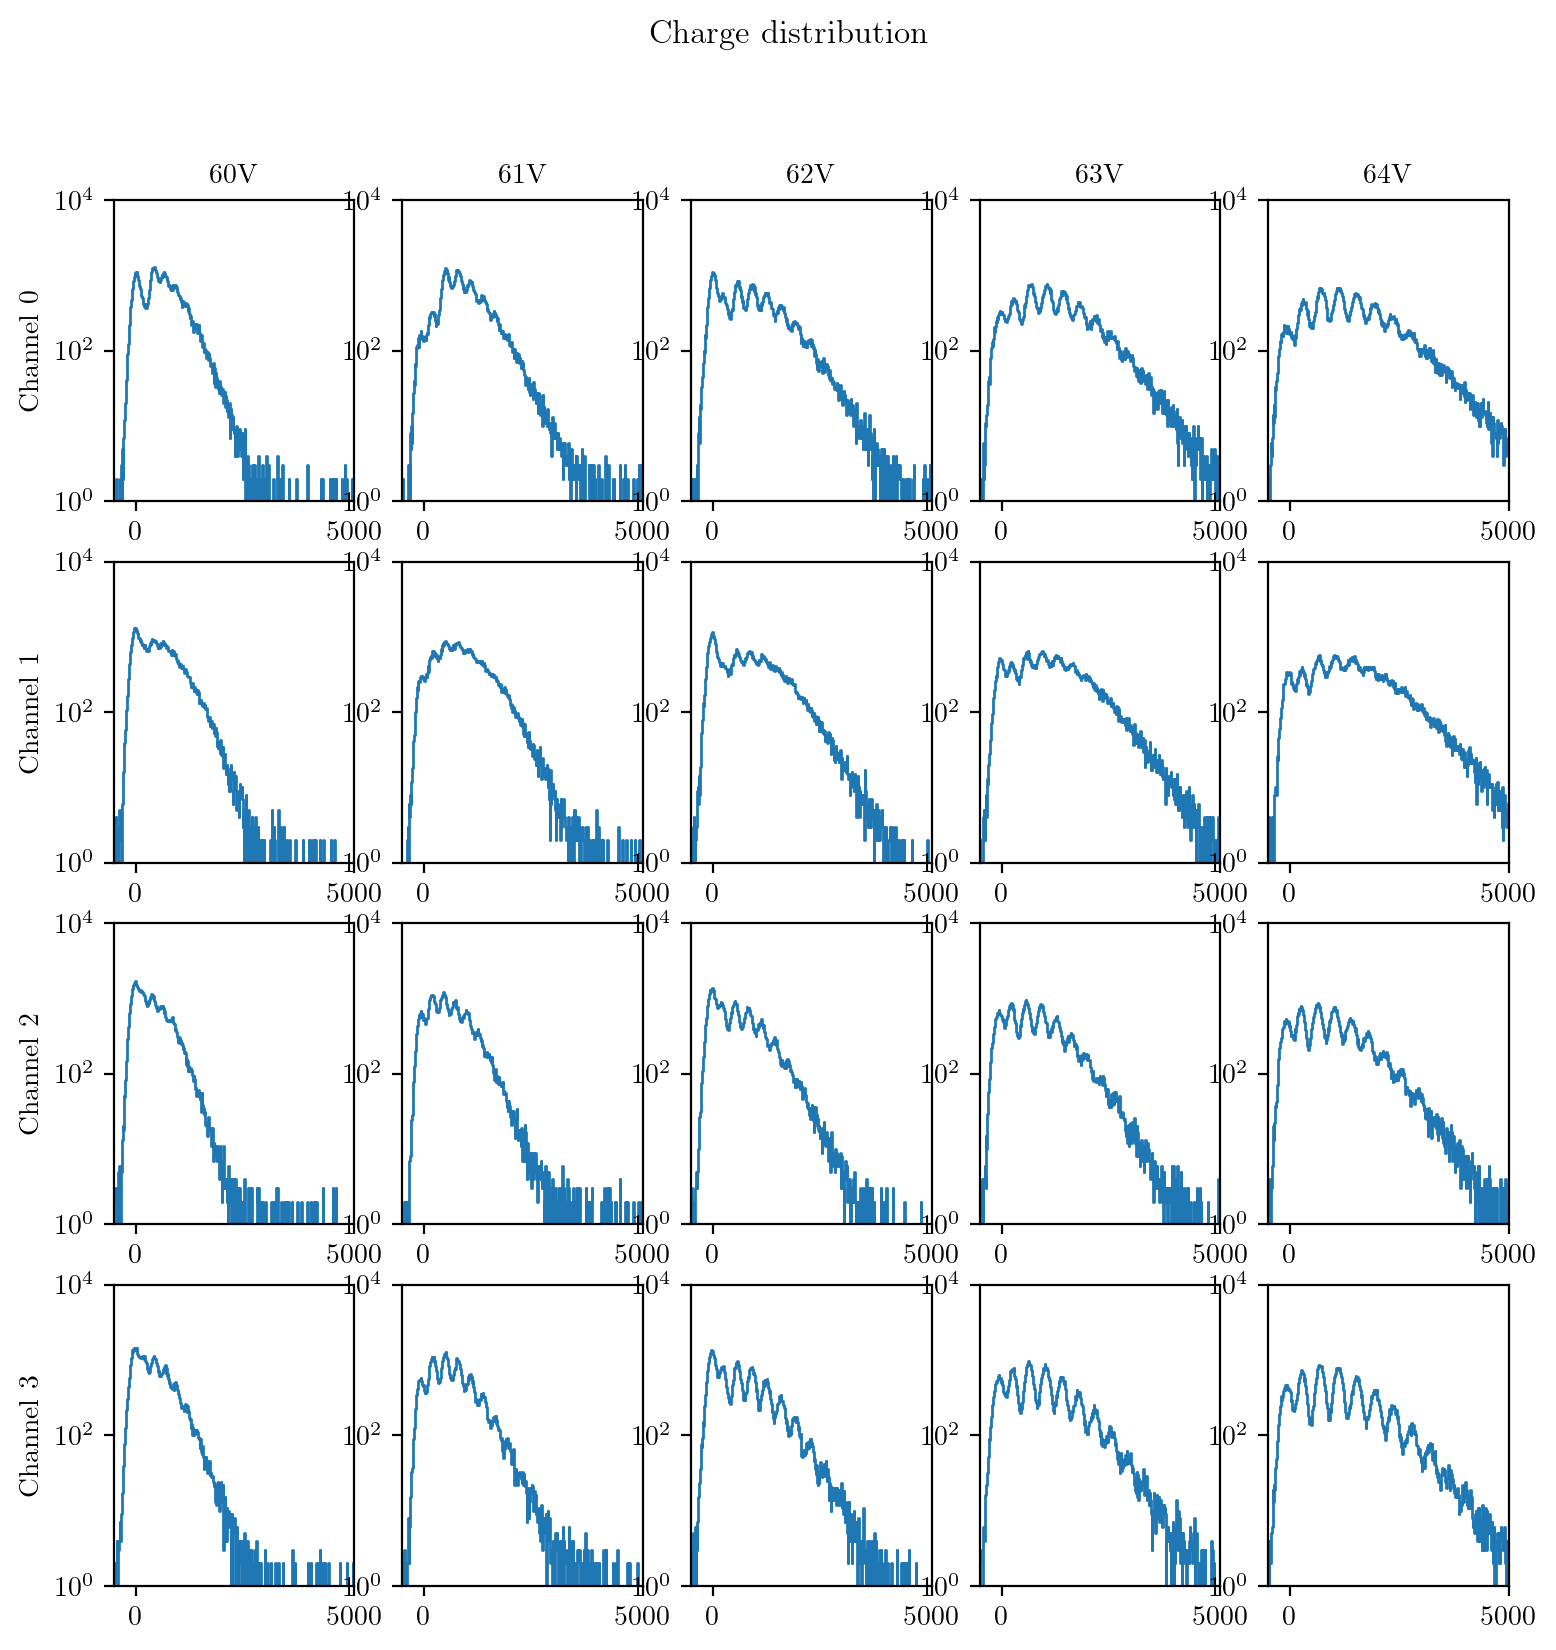

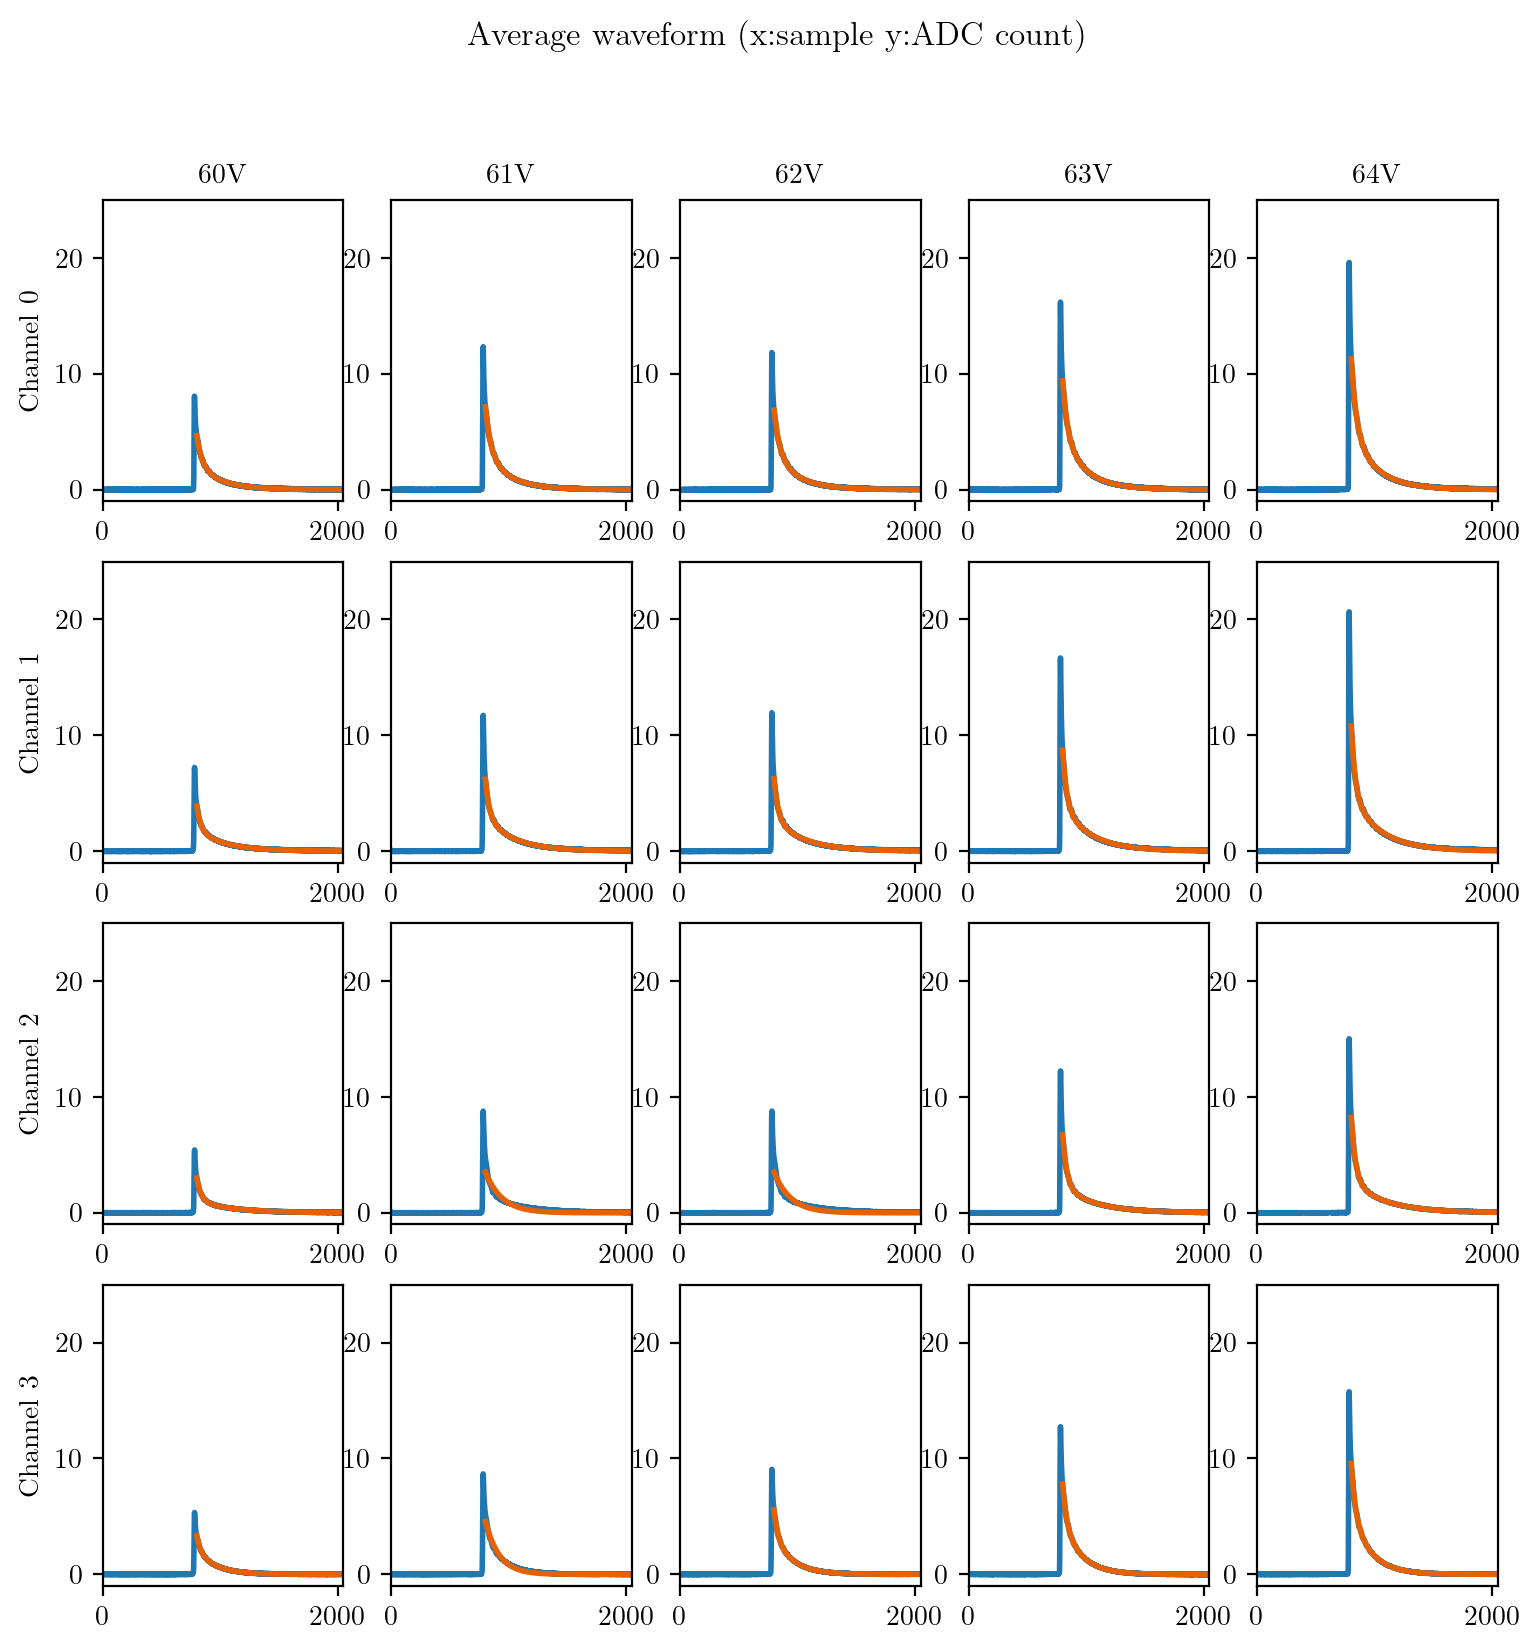

In [10]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [60, 61, 62, 63, 64]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs_sub_bsl = wfs
        integrals = []
        for i,wf in enumerate(wfs):
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            integrals.append(np.sum(wfs_sub_bsl[i][750:1200])) #integral between sample 750 and 1200
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 5000, 500))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 5000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in wfs_sub_bsl:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(800,2047,2048-800), meanwf[800:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(800,2047,2048-800), expo_pulse(np.linspace(800,2047,2048-800),*popt))
        print(popt)
        plt.xlim(0,2048)
        plt.ylim(-1, 25)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

## Auto-regressive filter

In [7]:
h_ampfilt_ch_volt = np.zeros((4,5,1000))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,1000))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 40 #AR filter parameter (should = time constant of pulse shape)
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:600],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt,axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 1000, 1001))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

NameError: name 'voltages' is not defined

Channel 0 Vbd=54.651+/-0.106V
Channel 1 Vbd=54.671+/-0.145V
Channel 2 Vbd=54.722+/-0.042V
Channel 3 Vbd=54.881+/-0.016V


Text(0.5, 0.98, 'Breakdown Voltage')

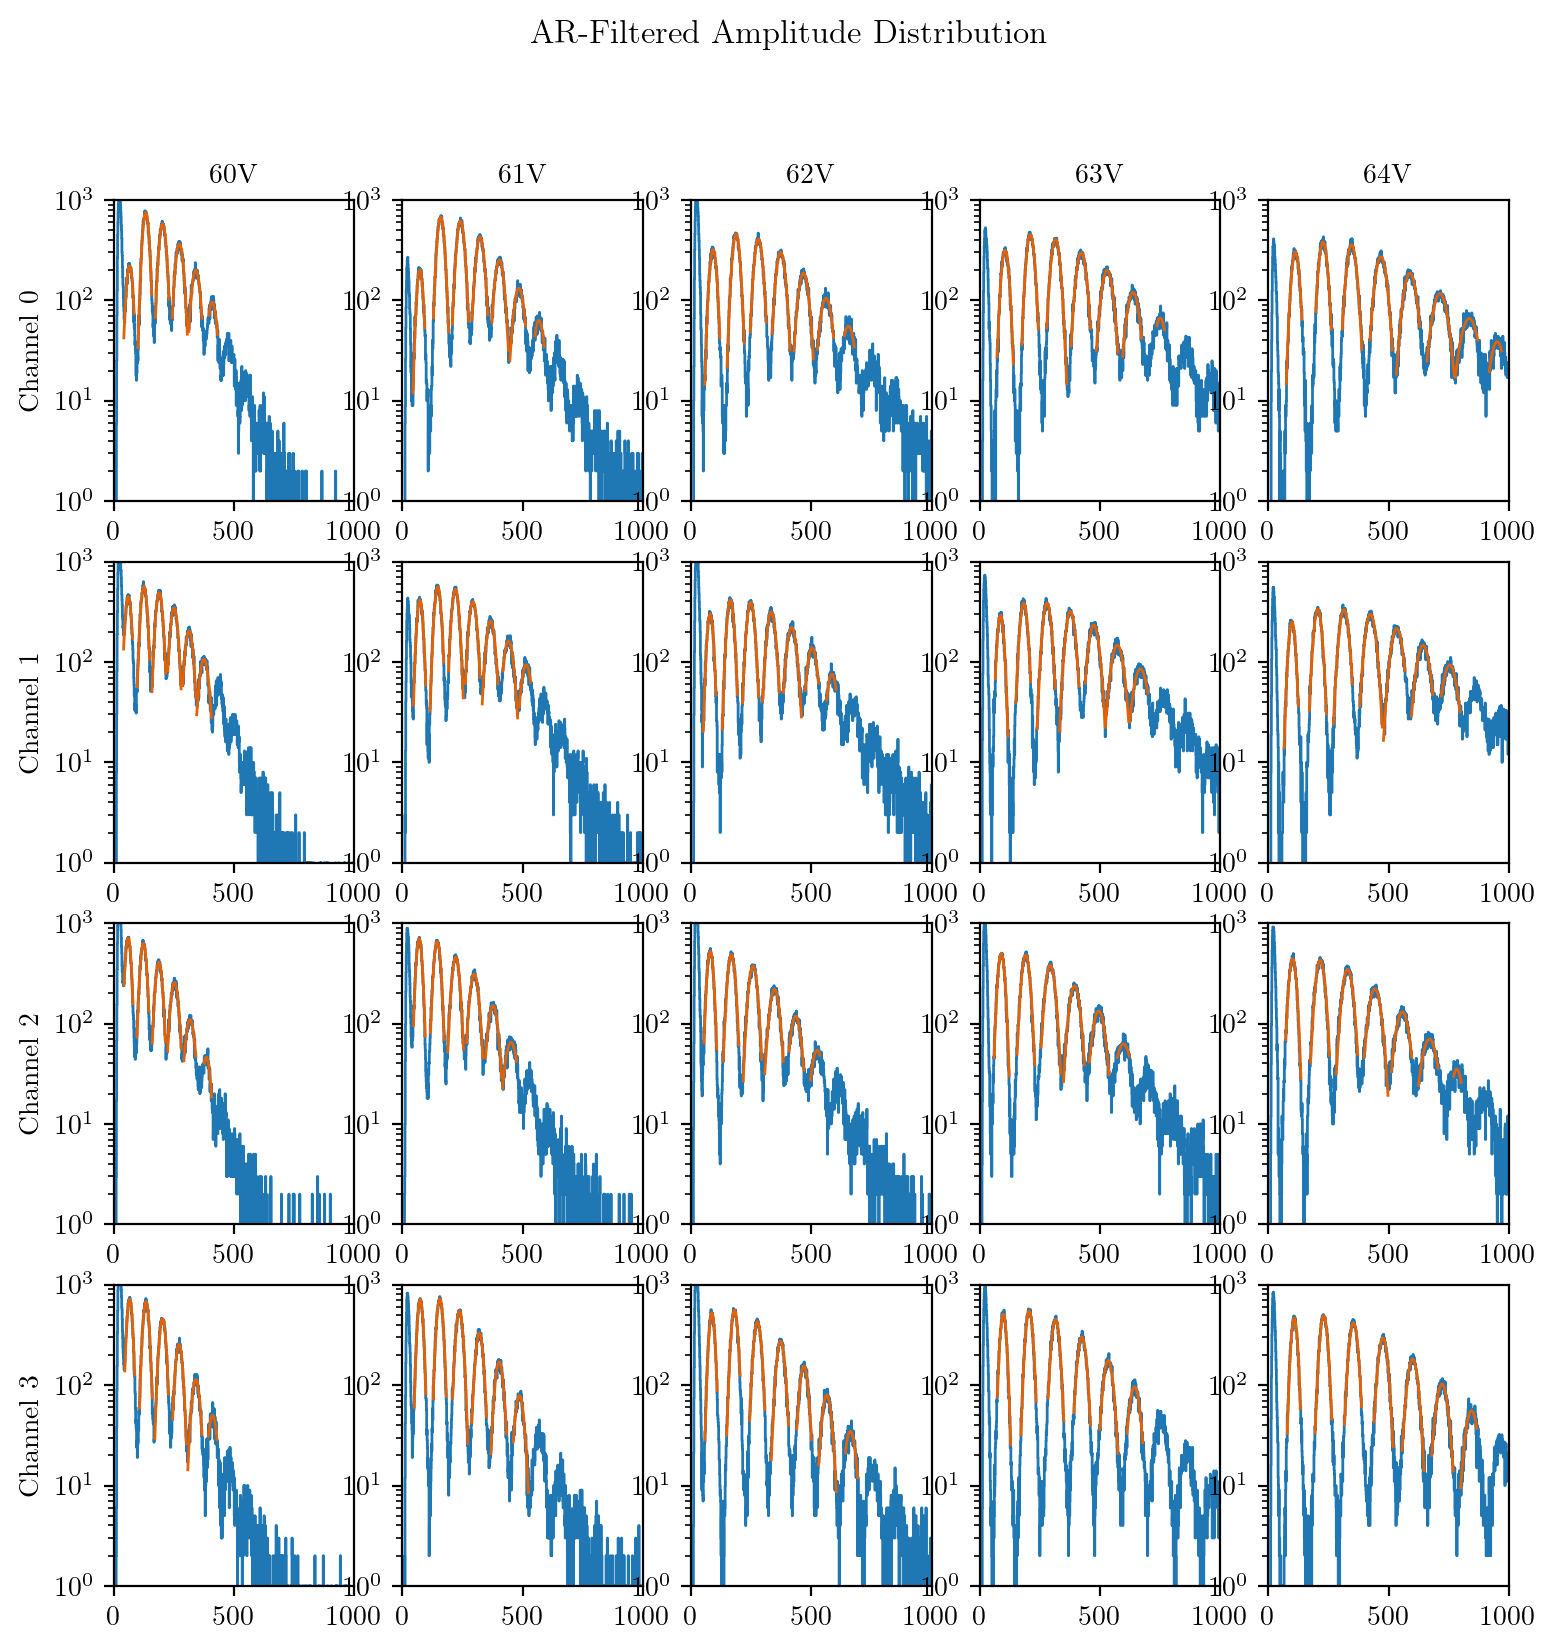

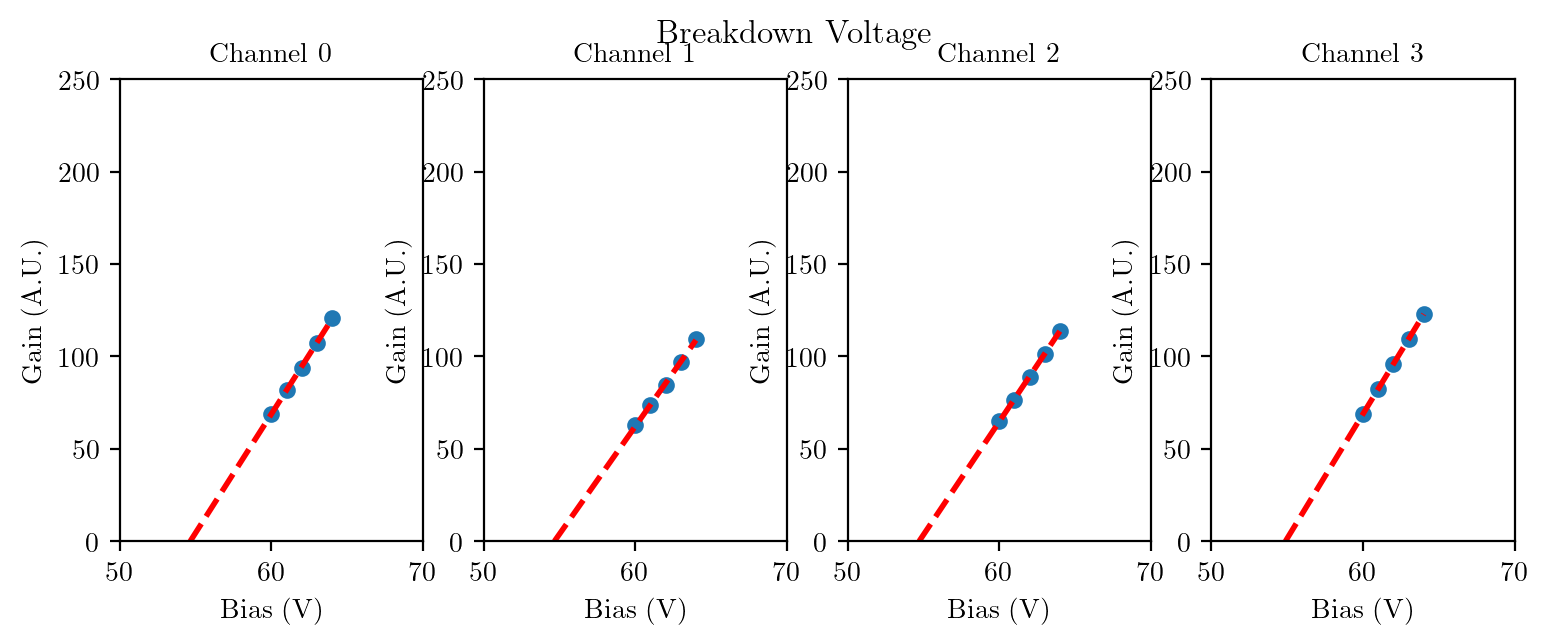

In [29]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [60, 61, 62, 63, 64]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][30:], prominence=20, width=15, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + 30
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
#         print("gain={}(au)".format(popt[0]))
        gain_fit.append(popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')

# Bottom tile directories (0926 data)

In [6]:
voltages = ['20220926_bottom_65V_laser_thres3715',
            '20220926_bottom_67V_laser_thres3712',
            '20220926_bottom_69V_laser_thres3710',
            '20220926_bottom_71V_laser_thres3706',
            '20220926_bottom_73V_laser_thres3703']

ch0 20220926_bottom_65V_laser_thres3715
trigger position: sample 782
a1=13.5665 tau1=331.3431 a2=114.8143 tau2=30.7736
ch0 20220926_bottom_67V_laser_thres3712
trigger position: sample 782
a1=33.9286 tau1=306.1795 a2=286.4979 tau2=29.0154
ch0 20220926_bottom_69V_laser_thres3710
trigger position: sample 782
a1=40.9731 tau1=303.6324 a2=343.8756 tau2=29.2659
ch0 20220926_bottom_71V_laser_thres3706
trigger position: sample 782
a1=57.1488 tau1=301.3161 a2=461.2446 tau2=30.2696
ch0 20220926_bottom_73V_laser_thres3703
trigger position: sample 782
a1=69.1229 tau1=294.5330 a2=532.6342 tau2=30.9984
ch1 20220926_bottom_65V_laser_thres3715
trigger position: sample 782
a1=8.8454 tau1=406.6827 a2=112.6670 tau2=35.2579
ch1 20220926_bottom_67V_laser_thres3712
trigger position: sample 783
a1=20.9732 tau1=382.9150 a2=263.7749 tau2=34.8645
ch1 20220926_bottom_69V_laser_thres3710
trigger position: sample 783
a1=24.8917 tau1=385.1538 a2=313.3224 tau2=35.3573
ch1 20220926_bottom_71V_laser_thres3706
trigger p

Text(0.5, 0.98, 'Average waveform (x:sample y:ADC count)')

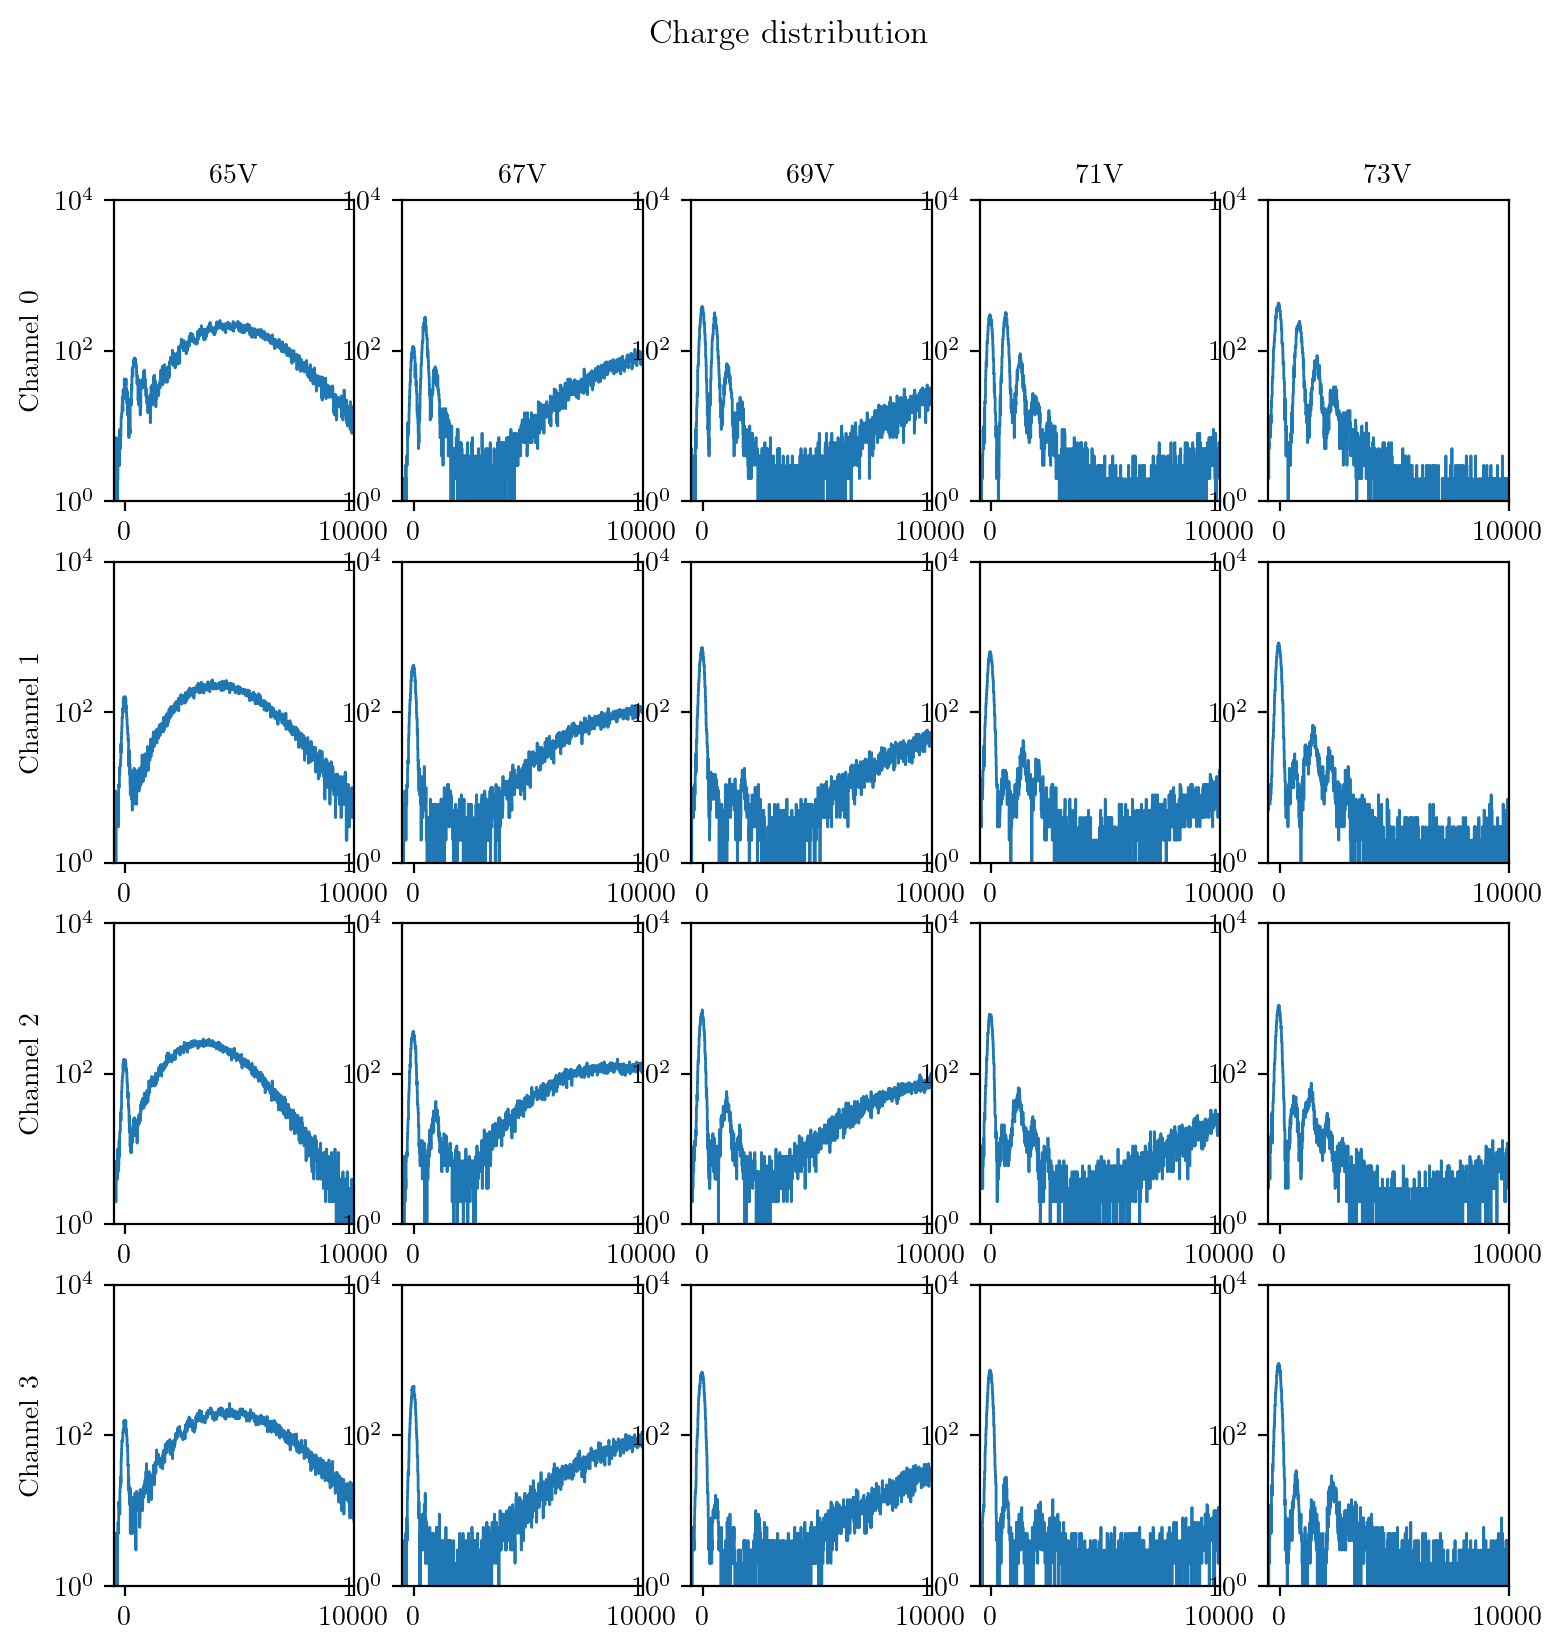

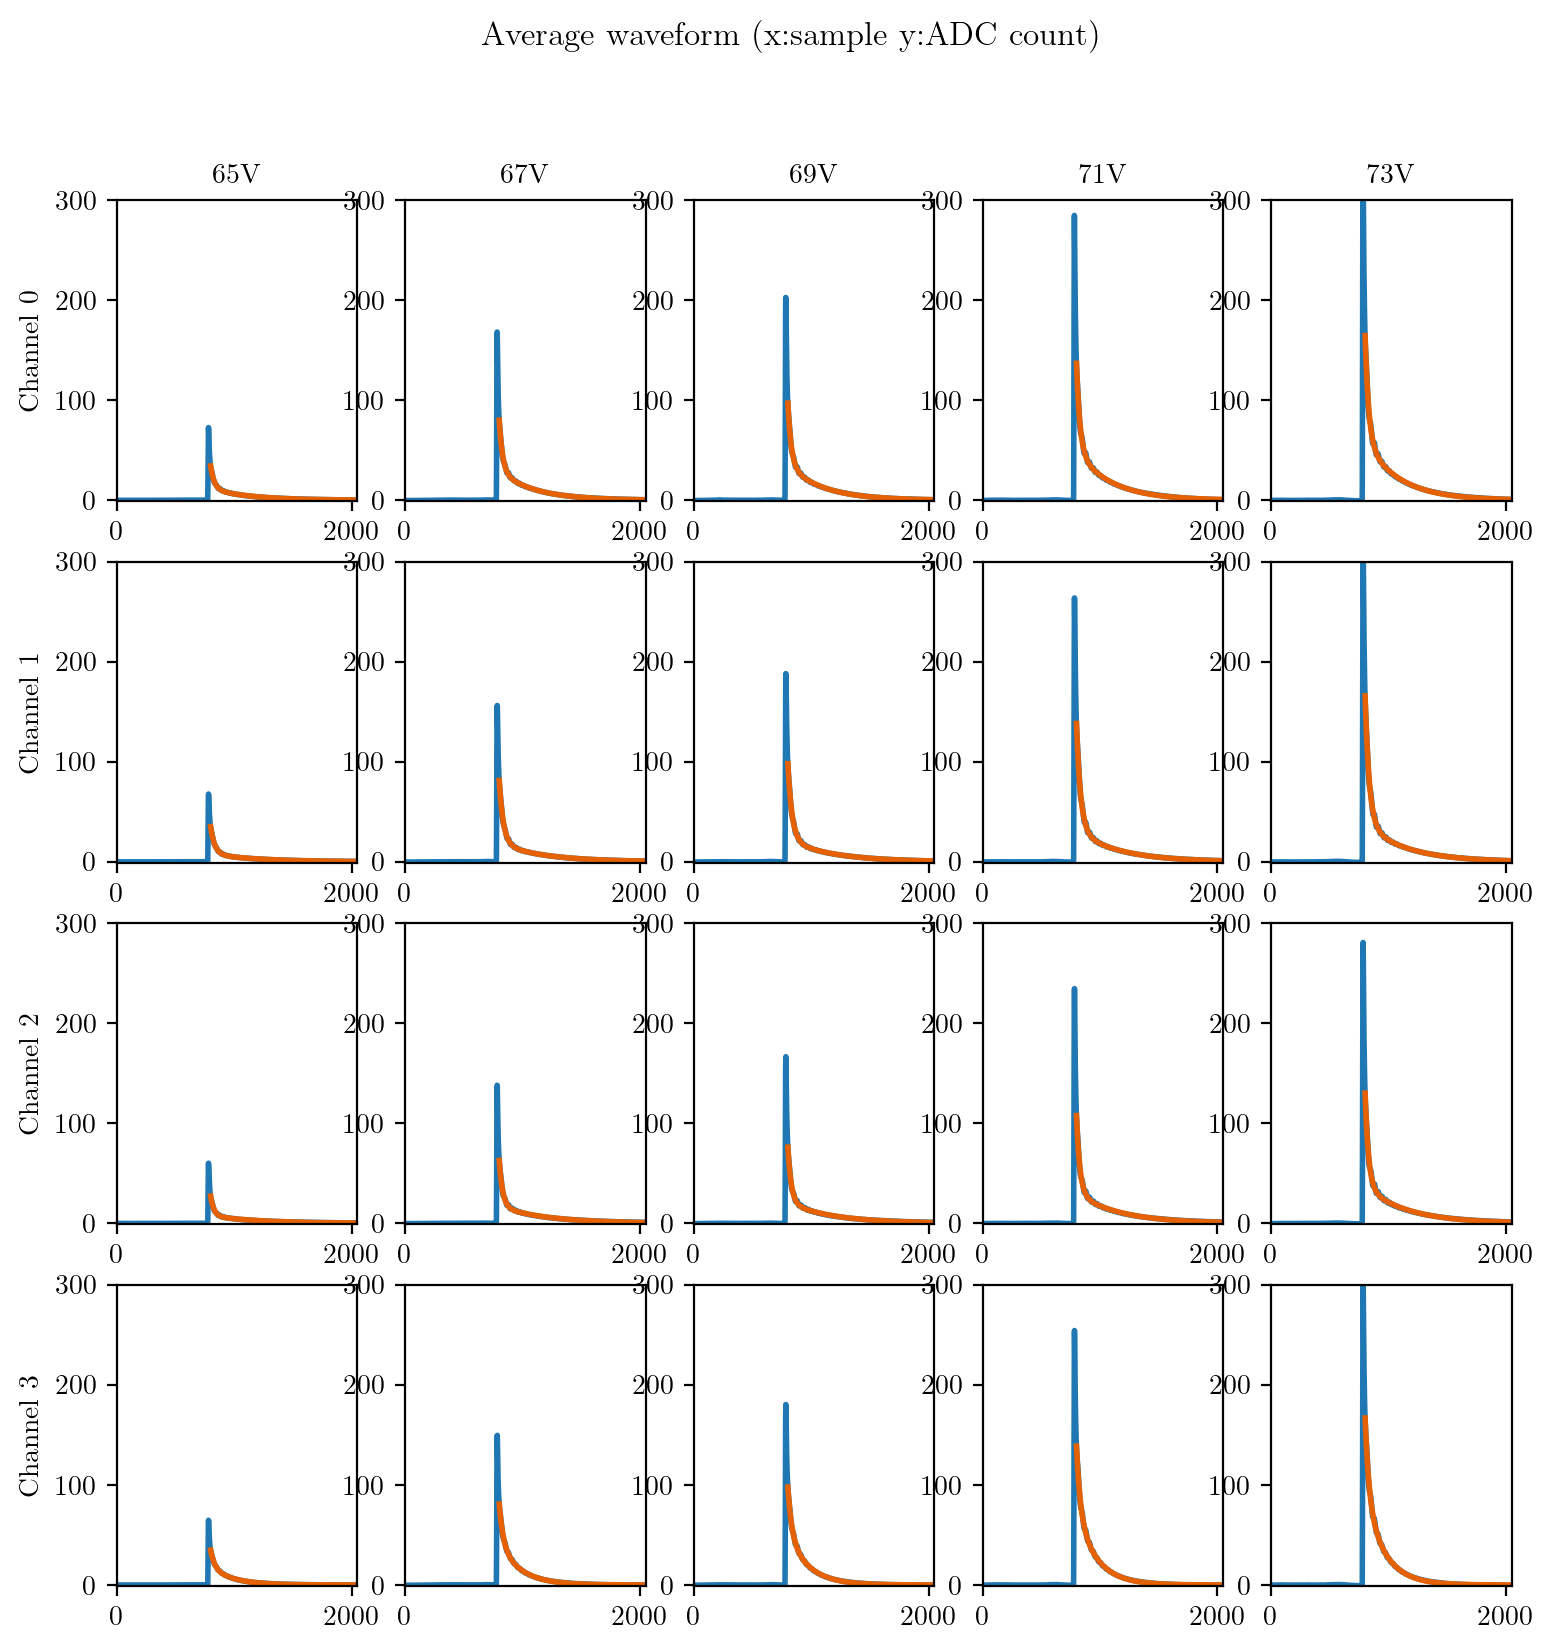

In [11]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,9))#for avg waveform histograms
bias = [65, 67, 69, 71, 73]
for ch in [0,1,2,3]:
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        wfs = traces.reshape((-1,2048)).astype(float)
        wfs_sub_bsl = wfs
        integrals = []
        for i,wf in enumerate(wfs):
            wfs_sub_bsl[i] = - wf + np.mean(wf[:600]) #subtract baseline (avg. of first 600 samples)
            integrals.append(np.sum(wfs_sub_bsl[i][750:1300])) #integral between sample 750 and 1200
        #charge histogram
        h_intg, h_intg_bins = np.histogram(integrals, bins=np.linspace(-500, 10000, 1000))#linspace(min, max, nbins)
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_intg_bins[:-1], h_intg, linewidth=1)
        plt.yscale('log')
        plt.xlim(-500, 10000)
        plt.ylim(1,1e4)

        # average waveform
        meanwf = np.zeros(2048)
        count = 0
        for wf_sub_bsl in wfs_sub_bsl:
            meanwf = meanwf*count + wf_sub_bsl
            count += 1
            meanwf = meanwf/count
        print("trigger position: sample {}".format(np.argmax(meanwf)))
        plt.figure(1)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(meanwf)
        popt,pcov = curve_fit(expo_pulse, np.linspace(800,2047,2048-800), meanwf[800:], p0=[10,100,10,10],maxfev=10000)
        plt.plot(np.linspace(800,2047,2048-800), expo_pulse(np.linspace(800,2047,2048-800),*popt))
        print("a1={:.4f} tau1={:.4f} a2={:.4f} tau2={:.4f}".format(*popt))
        plt.xlim(0,2048)
        plt.ylim(-1, 300)
plt.figure(0)
plt.suptitle('Charge distribution')
plt.figure(1)
plt.suptitle('Average waveform (x:sample y:ADC count)')

In [9]:
nbins = 500
h_ampfilt_ch_volt = np.zeros((4,5,nbins))
h_ampfilt_bincent_ch_volt = np.zeros((4,5,nbins))
h_ampfilt_binwid_ch_volt = np.zeros((4,5))
tau = 30 #AR filter parameter (should = time constant of pulse shape)
timewindow=[775,790]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        print("ch{} {}".format(ch, volt))
        fname = "/home/aj9512/jadwin-365/data/sipm/{}/wave{}.dat".format(volt,ch)
        dt = np.dtype('<H')
        file = open(fname, 'rb')
        traces = np.fromfile(file, dtype=dt, count=-1)
        file.close()

        traces = traces.reshape((-1,2048)).astype(float)
        #traces = traces[:10000] #use first 10000 waveforms
        traces = np.tile(np.mean(traces[:,:600],axis=1).reshape(100000,1),(1,2048)) - traces

        wfs_filt = AR_filter(traces, tau)
        amps_filt = np.max(wfs_filt[:,timewindow[0]:timewindow[1]],axis=1)
        
        #filtered amplitude histogram
        h_ampfilt, h_ampfilt_bins = np.histogram(amps_filt, bins=np.linspace(0, 2000, nbins+1))#linspace(min, max, nbins)
        h_ampfilt_bincent_ch_volt[ch][volt_id] = (h_ampfilt_bins[1:]+h_ampfilt_bins[:-1])/2
        h_ampfilt_ch_volt[ch][volt_id] = h_ampfilt
        h_ampfilt_binwid_ch_volt[ch][volt_id] = h_ampfilt_bins[1]-h_ampfilt_bins[0]

ch0 20220926_bottom_65V_laser_thres3715
ch0 20220926_bottom_67V_laser_thres3712
ch0 20220926_bottom_69V_laser_thres3710
ch0 20220926_bottom_71V_laser_thres3706
ch0 20220926_bottom_73V_laser_thres3703
ch1 20220926_bottom_65V_laser_thres3715
ch1 20220926_bottom_67V_laser_thres3712
ch1 20220926_bottom_69V_laser_thres3710
ch1 20220926_bottom_71V_laser_thres3706
ch1 20220926_bottom_73V_laser_thres3703
ch2 20220926_bottom_65V_laser_thres3715
ch2 20220926_bottom_67V_laser_thres3712
ch2 20220926_bottom_69V_laser_thres3710
ch2 20220926_bottom_71V_laser_thres3706
ch2 20220926_bottom_73V_laser_thres3703
ch3 20220926_bottom_65V_laser_thres3715
ch3 20220926_bottom_67V_laser_thres3712
ch3 20220926_bottom_69V_laser_thres3710
ch3 20220926_bottom_71V_laser_thres3706
ch3 20220926_bottom_73V_laser_thres3703


Channel 0 Vbd=37.673+/-45.668V
Channel 1 Vbd=70.477+/-1.578V
Channel 2 Vbd=45.952+/-57.570V
Channel 3 Vbd=63.263+/-6.957V


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage')

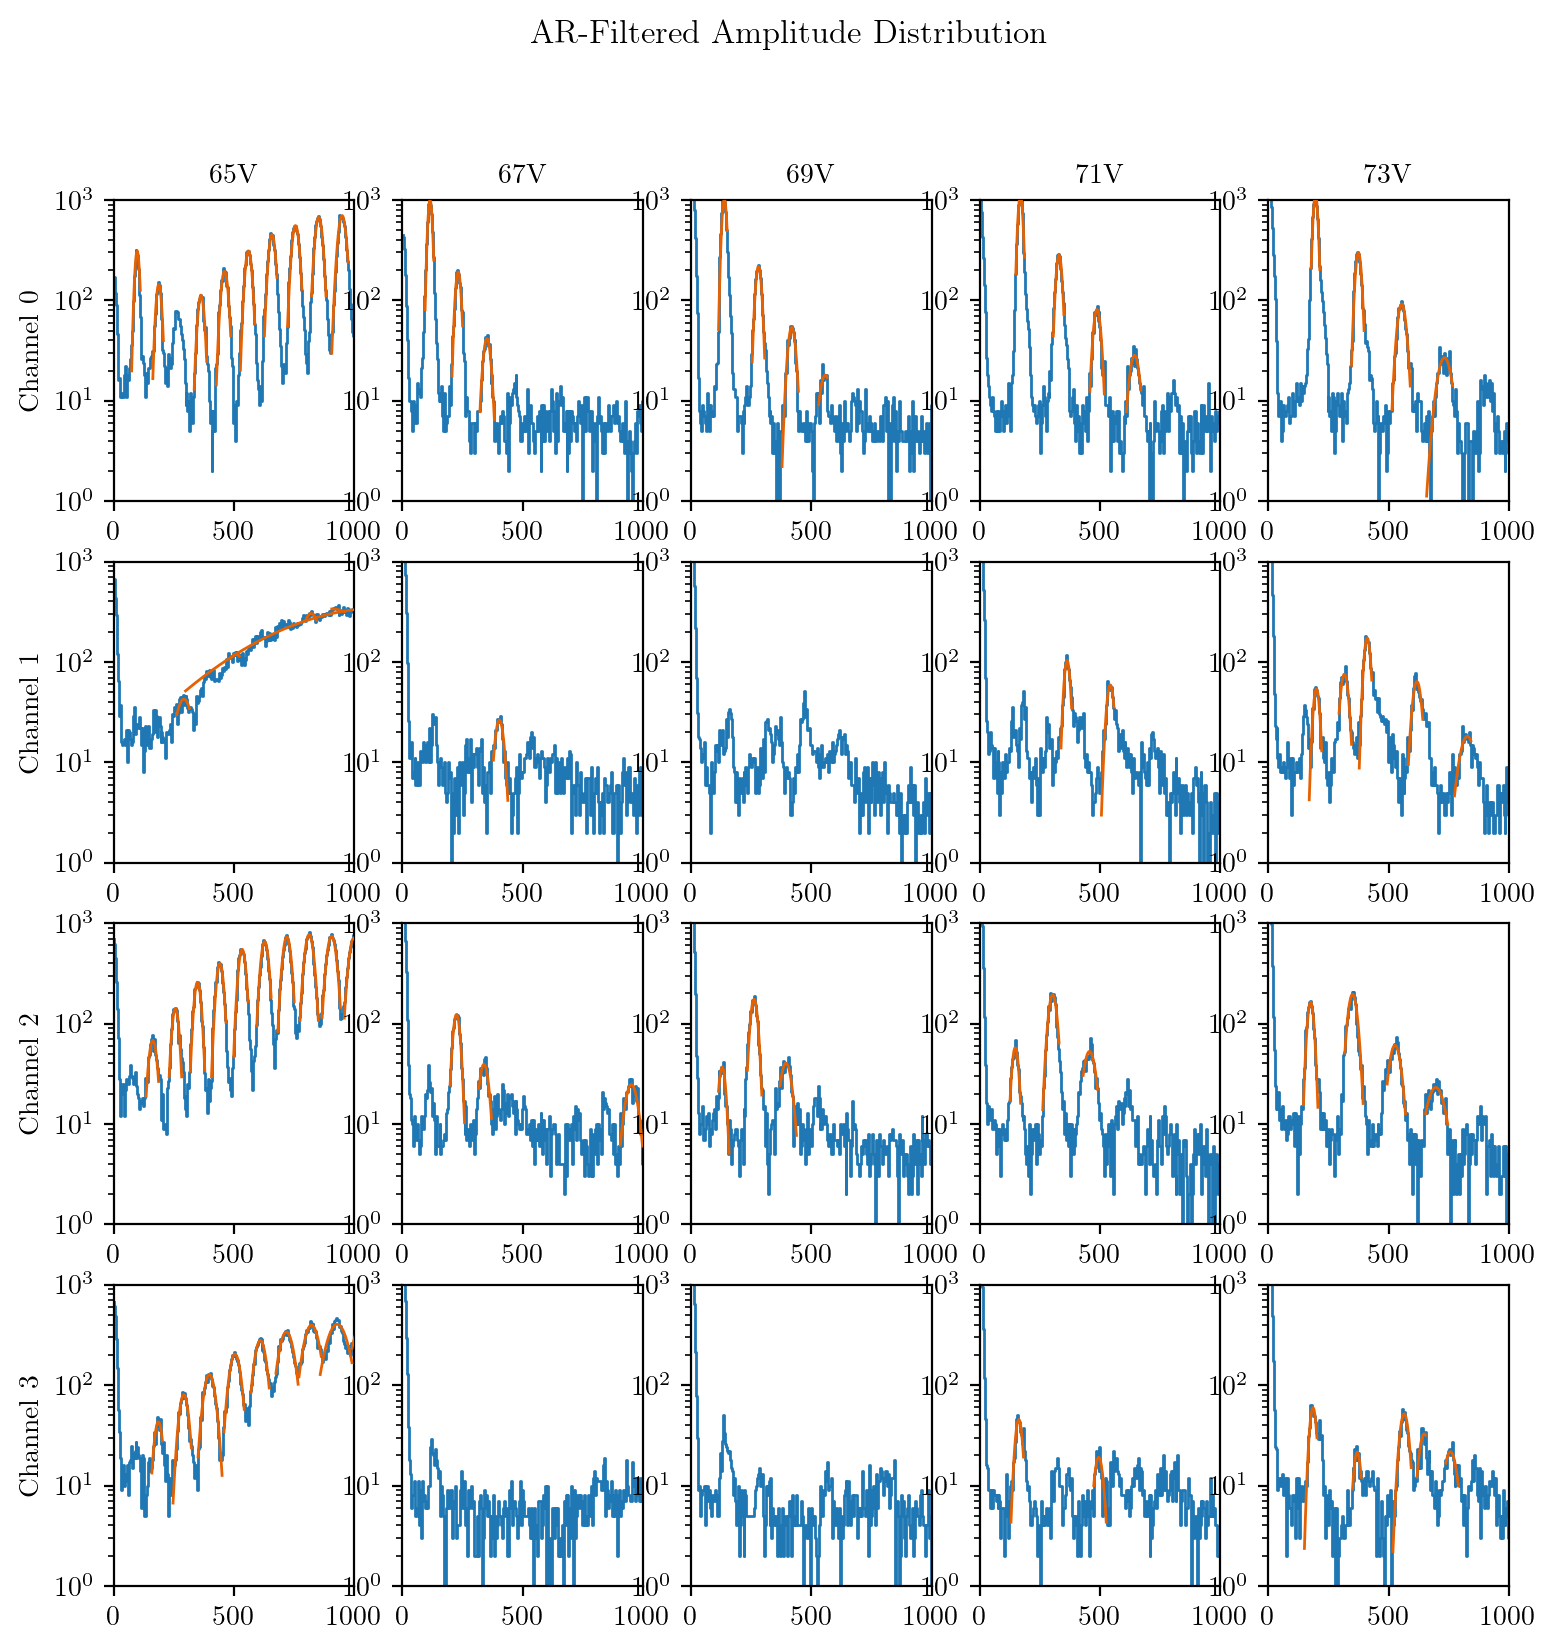

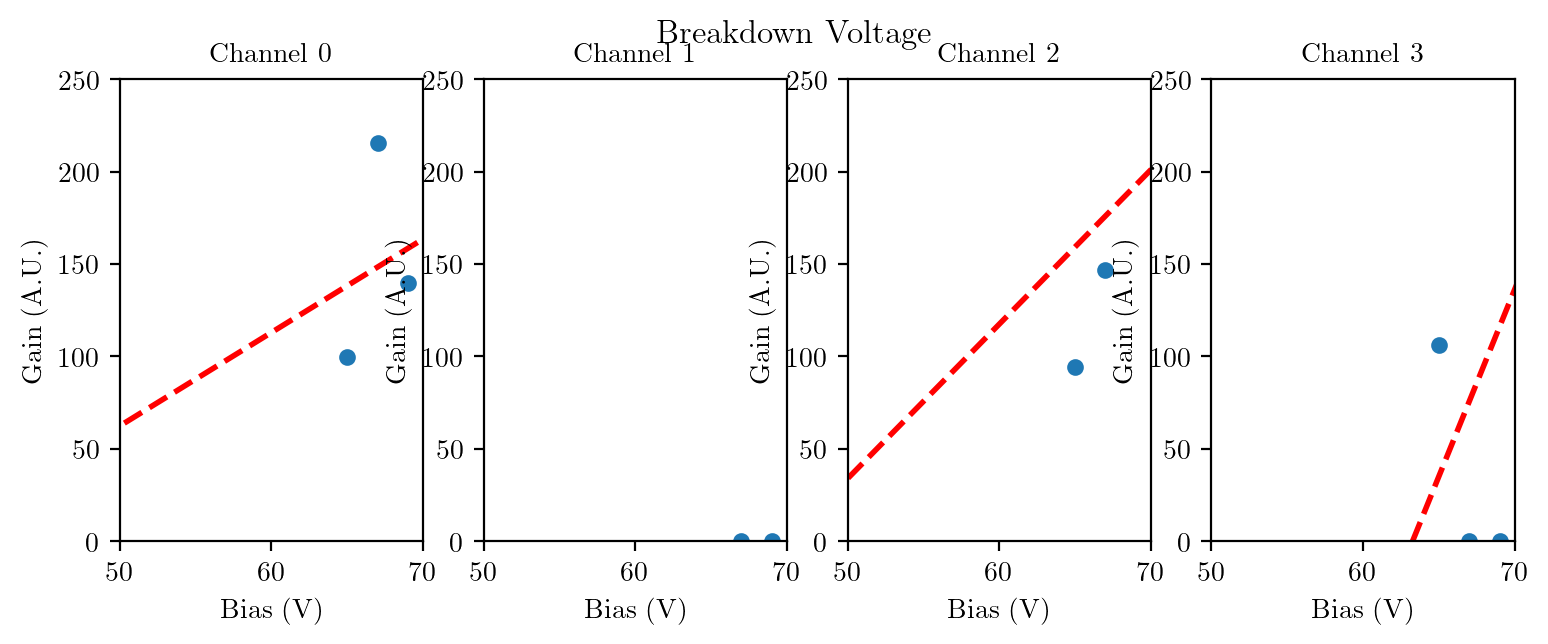

In [10]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [65, 67, 69, 71, 73]
for ch in range(4):
    gain_fit = []
    for volt_id,volt in enumerate(voltages): 
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+volt_id+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[volt_id]))
        if volt_id==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.step(h_ampfilt_bincent_ch_volt[ch][volt_id], h_ampfilt_ch_volt[ch][volt_id], linewidth=1)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        threshold = 15 #
        peaks,pdict = find_peaks(h_ampfilt_ch_volt[ch][volt_id][threshold:], prominence=20, width=5, distance=20)
#         print("peaks:", peaks)
#         print("pdict:", pdict)
        #fit pe peaks with Gaussian
        pe_mean = []
        
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + threshold
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = h_ampfilt_binwid_ch_volt[ch][volt_id]*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*min_bin
            max_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*max_bin
            peak_x = h_ampfilt_bincent_ch_volt[ch][volt_id][0] + h_ampfilt_binwid_ch_volt[ch][volt_id]*peak_bin
            popt,pcov = curve_fit(gauss, h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], h_ampfilt_ch_volt[ch][volt_id][min_bin:max_bin], p0=[h_ampfilt_ch_volt[ch][volt_id][peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], gauss(h_ampfilt_bincent_ch_volt[ch][volt_id][min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
#             print("[N,mu,sigma]={}".format(popt))
            pe_mean.append(popt[1])
        
        #fit pe-mean vs pe with linear
        if len(peaks)>1:
            xlin = np.linspace(1,len(peaks),len(peaks))
            ylin = pe_mean
            popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
    #         print("gain={}(au)".format(popt[0]))
            gain_fit.append(popt[0])
        else:
            gain_fit.append(0)
    #breakdown voltage fit and plot
    xlin = bias
    ylin = gain_fit
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V".format(ch,popt[1],np.sqrt(pcov[1,1])))
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,70)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution')
plt.figure(1)
plt.suptitle('Breakdown Voltage')